In [1]:
# imports

# data and graphics
import h5py    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# motion correction: https://image-registration.readthedocs.io/en/latest/image_registration.html
from image_registration import chi2_shift
from image_registration.fft_tools import shift
import image_registration

# alternative, image registration, not as good
# import imreg_dft as ird

# image registration
# https://pypi.org/project/pystackreg/
# from pystackreg import StackReg

# signal processing
import scipy
from scipy import signal
from scipy.signal import butter,sosfiltfilt, general_gaussian, sosfreqz, detrend, coherence
from scipy.ndimage import median_filter
from scipy.stats import pearsonr

# movie
import imageio

# bladder pressure analysis
import adi

%matplotlib inline

In [2]:
# Author:
#  input - .scan file name string. Example: 'recording_1_filename.scan' % output - 3D and 4D fUSI pD data matrices
 
def import_file(scanFN):
    '''
    Import .scan file from fUS
    '''
    
    with h5py.File(scanFN, 'r') as file:
        mat4D = file['Data'][:]  # Read data from '/Data' dataset

    mat3D = np.squeeze(mat4D)

    return mat3D

# Explore HDF5 file structure
def explore_hdf5_group(group, indent=0):
    for name, item in group.items():
        print(" " * indent + f"Name: {name}, Type: {type(item)}")
        
        if isinstance(item, h5py.Group):
            explore_hdf5_group(item, indent + 2)
        elif isinstance(item, h5py.Dataset):
            print(" " * (indent + 2) + f"Shape: {item.shape}, Dtype: {item.dtype}")
        print()

def explore_hdf5_structure(filename):
    with h5py.File(filename, 'r') as file:
        explore_hdf5_group(file)

def bandpass(data, cutoff, fs=1, order=2):
    ''' Bandpass filter '''
    sos = butter(order, np.array(cutoff), fs=fs, btype='bandpass', output='sos', analog=False)
    y = sosfiltfilt(sos, data, axis=0)
    return y

def lowpass(data, cutoff, fs=10000, order=2):
    ''' Low pass filter '''
# no need to do this if specifying fs in butter() function
#     nyq = .5 * fs
#     normal_cutoff = cutoff/nyq
    sos = butter(order, cutoff, fs=fs, btype='lowpass', output='sos', analog=False) #fs=fs, 
    y = sosfiltfilt(sos, data, axis=0)
    return y

# discretize
def discretize(img):
    return img>np.percentile(img,97.5)

# general gaussian filter to reduce border artefact (fft assumes periodic boundaries)
def gaussfit(img):
    from scipy.signal import general_gaussian
    window = np.outer(general_gaussian(img.shape[0],10,50),general_gaussian(img.shape[1],10,70))
    return window*img

# register all to baseline image
def motioncorrect(idx):
    ''' This only shift x and y, does not rotate.
    
    https://image-registration.readthedocs.io/en/latest/image_registration.html
    '''
    
    assert np.min(mat3D_orig[idx,...])>=0, f"{idx} not recommended to perform square"
    
    ref = np.sqrt(mat3D_orig[0,...]) # this compresses the data to reduce fourier transform artefacts arising from high-signal vessels
    img = np.sqrt(mat3D_orig[idx,...])

    xoff, yoff, exoff, eyoff = chi2_shift(ref, img, zeromean=True, boundary='nearest')
            
    return shift.shiftnd(img, (-np.round(yoff,2), -np.round(xoff,2)))**2

# utility functions
def minmax(arr):
    return (arr-arr.min())/(arr.max()-arr.min())

def normalize(arr):
    return (arr-arr.mean())/arr.std()

def to2D(m):
    return m.reshape(mat3D.shape[0],-1)

def to3D(m):
    return m.reshape(mat3D.shape)

def pickPixel(img):
    import cv2

    positions = cv2.pick(img)
    print(positions)

In [356]:
# --- UDS
fnames = [r"ses-Session_2023-11-13_UDS_Rat1_parasagittal\sub-fUSXX_ses-Session_2023-11-13_UDS_Rat1_2Dscan_1_fus2D.source.scan", #0 20231113 parasagittal
         r"ses-Session_2023-11-13_UDS_Rat1_coronal\sub-fUSXX_ses-Session_2023-11-13_UDS_Rat2_fus2D.source.scan", #1 20231113 coronal
         r"ses-Session_2023-11-14_UDS_Rat1_parasagittal\sub-fUSXX_ses-Session_2023-11-14_UDS_Rat1_2Dscan_1_fus2D.source.scan", #2 20231114 parasagittal
         r"ses-Session_2023-11-14_UDS_Rat1_coronal\sub-fUSXX_ses-Session_2023-11-14_UDS_rat1_coronal_fus2D.source.scan", #3 20231114 coronal
         r"ses-Session_2023-11-28_UDS_Parasagittal\sub-fUSXX_ses-Session_2023-11-28_UDS_Parasagittal_2Dscan_1_fus2D.source.scan", #4 20231128 parasagittal
         r"ses-Session_2023-11-28_UDS_Coronal\sub-fUSXX_ses-Session_2023-11-28_UDS_Coronal_2Dscan_1_fus2D.source.scan", #5 20231128 coronal
         r"ses-Session_2023-12-05_UDS_Parasagittal\sub-fUSXX_ses-Session_2023-12-5_UDS_Parasagittal_2Dscan_2_fus2D.source.scan", #6 20231205 parasagittal
         r"ses-Session_2023-12-05_UDS_Coronal\sub-fUSXX_ses-Session_2023-12-5_UDS_Coronal_2Dscan_1_fus2D.source.scan", #7 20231205 coronal
         r"ses-Session_2023-12-08_UDS_Rat1_parasagittal\sub-fUSXX_ses-Session_2023-12-8_2Dscan_2_fus2D.source.scan", #8 20231208 parasagittal
         r"ses-Session_2023-12-08_UDS_Rat1_coronal\sub-fUSXX_ses-Session_2023-12-8_UDS_Coronal_2Dscan_1_fus2D.source.scan", #9 20231208 coronal
         r"ses-Session_2023-12-11_UDS_Rat1_parasagittal\sub-fUSXX_ses-Session_2023-12-11_UDS_Parasagittal_2Dscan_3_fus2D.source.scan", #10 20231211 parasagittal
         r"ses-Session_2023-12-11_UDS_Rat1_coronal\sub-fUSXX_ses-Session_2023-12-11_UDS_Coronal_fus2D.source.scan" #11 20231211 coronal
         ]
select=10

mat3D = import_file(fnames[select])
mat2D = to2D(mat3D)
mat2D_orig = mat2D.copy()
mat3D_orig = mat3D.copy() # backup

In [357]:
# motion correct
mat3D_corr = np.zeros_like(mat3D)
missing = np.zeros_like(mat3D)

print('assessing frame...', end=' ')
for i in range(mat3D.shape[0]):
#for i in range(1800,1900):
    # -- motion correct using ORB and RANSAC
    print(i, end=' ')
    mat3D_corr[i, ...] = motioncorrect(i)
    
# show difference maps due to motion correction - most of the pixels should remain unchanged
# plt.imshow(mat3D[40,...]-mat3D_corr[40,...], cmap='Accent'), plt.colorbar()

# # --- export mp4 as movie
# imageio.mimwrite(f'rat UDS{select}_motion_corrected.mp4', np.sqrt(mat3D_corr), fps = 30)

assessing frame... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272

1857 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 

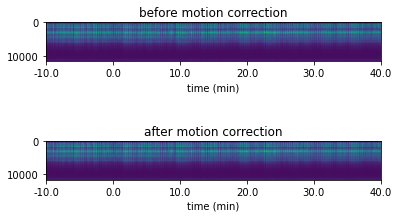

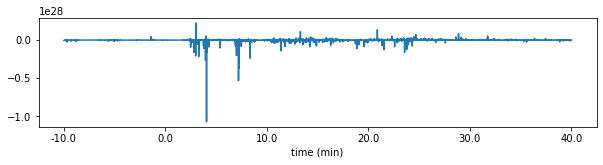

In [358]:
# visualize which segments are most affected by motion stabilization
fig, ax = plt.subplots(2,1)
ax[0].imshow(to2D(mat3D_orig).T, aspect=.03, vmax=100, vmin=0) # before motion correction
locs=np.array([0,10,20,30,40,50])*60
ax[0].set_xticks(locs, labels=np.round(locs/60,0)-10), ax[0].set_xlabel('time (min)')
ax[0].set_title('before motion correction')

ax[1].imshow(to2D(mat3D_corr).T, aspect=.03, vmax=100, vmin=0) # after motion correction
ax[1].set_xticks(locs, labels=np.round(locs/60,0)-10), ax[1].set_xlabel('time (min)')
ax[1].set_title('after motion correction')
plt.show()

# mean rms difference
plt.figure(figsize=(10,2))
plt.plot(np.mean(((to2D(mat3D_corr)**2-to2D(mat3D_orig)**2)**5), axis=1))
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
plt.show()

# overwrite mat3D (optional)
mat3D = mat3D_corr.copy()
mat2D = to2D(mat3D)

# detrend pixel-wise to correct for baseline drift
mat2D=detrend(mat2D, axis=0)
mat3D=to3D(mat2D)

# subtract background fluctuations through median subtraction
mat2D-=np.median(mat2D,axis=1)[:,np.newaxis]
mat3D=to3D(mat2D)

# option to generate animation at this point

In [359]:
imageio.mimwrite(f'rat UDS{select}_motion_corrected.mp4', mat3D_corr, fps = 30)

Lossy conversion from float64 to uint8. Range [0.08213223472955347, 1223.1586862339416]. Convert image to uint8 prior to saving to suppress this warning.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (128, 91) to (128, 96) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Lossy conversion from float64 to uint8. Range [0.010384042750613606, 1151.4961106828487]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.009276454511331453, 1160.6755684695272]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [3.701838721216989e-05, 1078.502792994727]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.02962517972208

Lossy conversion from float64 to uint8. Range [0.009532116358898687, 1189.2496745286714]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03442258233786789, 1181.2769725516982]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04475462750681282, 1077.7673266385182]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03608087673588357, 984.7073553608157]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.25494918368048725, 1021.9426098482767]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.053213515976080795, 1475.8227145490168]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.043666127120380434, 1062.1

Lossy conversion from float64 to uint8. Range [0.12420265700126946, 1003.3748052742261]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.02608943908689961, 978.2946854273031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07919086333785705, 1112.3335511301134]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1234838973509309, 1060.9126437550522]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1310358212817304, 967.3541347587661]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.4326414103914683, 950.0914881605328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.284592946108907, 958.478223775063

Lossy conversion from float64 to uint8. Range [0.19498028694649838, 1059.2192986884527]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03481409487606369, 1093.1626011978813]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.005153589214923567, 1191.3382266114168]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.37251674549183983, 1162.2189436629103]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.27021457599506293, 1184.379186525395]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2122484805829314, 1520.1015734617538]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06208615839316834, 1328.7403

Lossy conversion from float64 to uint8. Range [0.40695890305014004, 1329.8371031403817]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3304671287366388, 1329.4243274934363]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2781410359665413, 1094.2260551057432]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.393982632243057, 1213.614613383902]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.10291898567731252, 990.7863526141041]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.13227454299683628, 1018.2431930809603]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.059106149503628407, 1046.46693407

Lossy conversion from float64 to uint8. Range [0.02169154625565887, 1122.3158596729972]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.025412990819820062, 1031.1678827055002]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00011304733024228946, 1216.1271018121108]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06869532803086283, 1190.8309735228117]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.008893469336968019, 1170.8936877337349]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06345783501509351, 1314.9320937670282]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03983714247728981, 156

Lossy conversion from float64 to uint8. Range [0.00014119222062164338, 1217.9918612355564]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.12997094512006468, 1071.365728396792]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0026712443085885602, 1100.1386555301347]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.016776995917290833, 1048.6420552790494]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.005273406574591685, 1108.7045255865828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03028032889426071, 1033.1540634059136]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.005456830186285689, 1

Lossy conversion from float64 to uint8. Range [0.11300473546620991, 1188.153304090763]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3496310496008059, 1039.0537949124775]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00044443369682607627, 1118.54876988216]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.005733585213337702, 1221.42415135786]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.14615082512382097, 1235.7465307014766]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0013374850497322797, 1123.466116008871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06461577607422295, 1175.4786

Lossy conversion from float64 to uint8. Range [0.6308127773906635, 1228.1258362337894]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.24389624729467044, 1157.083875499383]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.20051336991019092, 1313.176061789285]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2593573080774849, 1366.283398714036]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.09018998470286405, 1342.1939488019323]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2823034093078375, 1322.6878549938388]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.5796942047087252, 1522.2206793863

Lossy conversion from float64 to uint8. Range [0.0008883091074345778, 1111.4772714101634]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04072369799707551, 1142.2249925566061]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0019208289807982552, 1102.3996937277925]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0023207498277794114, 1192.5088752581526]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.10291510016042577, 1084.800705191108]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.28507620890584195, 1319.2544664462766]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07231266831517738, 131

Lossy conversion from float64 to uint8. Range [0.43624589313803325, 1253.2904496851104]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1762728444076399, 1187.9799554542428]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07562799768706949, 1626.4273550140979]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.027042488217527447, 1354.032760065852]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.18844555226922172, 1244.0398705655452]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0034281916945574672, 1216.6121423534396]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.05870385510228728, 1092.80

Lossy conversion from float64 to uint8. Range [0.013823296535796635, 1067.6607425861355]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.10336631635235351, 1074.4910708045047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.02725435039540437, 998.0843482189017]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.013393482953883729, 1067.962042823085]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.023354545512273218, 1221.0282397466299]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0003007723776762991, 1193.4365680401584]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.023177132133542454, 1022

Lossy conversion from float64 to uint8. Range [0.37897776787983783, 1249.3530831703956]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.022959240555055088, 1234.5580041696105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04307513151679904, 1149.1071894066001]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3558243976760258, 1041.7719047302114]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.4450147743504256, 1106.9727688112064]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.05007449945355627, 1184.7682837685566]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.017621878422537804, 1274.742

Lossy conversion from float64 to uint8. Range [0.3316733534667372, 849.3690778408422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0016956858361608337, 887.938875188073]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.10319742092540228, 934.9918031644672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3052904433794304, 1319.4112466693707]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.05450374163226772, 1326.106366149086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03894406583831574, 1279.7766846321795]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3347110270518505, 1413.665921563

Lossy conversion from float64 to uint8. Range [0.11718199110212318, 1200.1101569716789]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.021390780256870728, 1209.5482043320517]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0214252005026634, 1055.7497571557114]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1508444407779804, 1069.7708130687672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1726478631840013, 1215.1481115536637]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.013855327152020935, 1293.7166557885657]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.25030896401576475, 1214.0291

Lossy conversion from float64 to uint8. Range [0.002979084577928715, 906.9965622140148]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [3.9680959717567407e-05, 978.7391023736828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04603387147479046, 1139.4404031386941]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.4425714821259651, 1038.3619012971674]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.17755317869890297, 1078.4580529731409]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.13705124575998698, 1206.2845731510604]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.007873234478336799, 1151.2

Lossy conversion from float64 to uint8. Range [0.00593250070788034, 961.7878594743235]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.4474267556611756e-05, 1044.0234483464278]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [4.776166816084044e-07, 1222.5753078888845]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.22872316708729015, 1063.3248513237195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.08675722479933333, 950.9216628891203]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3747545693174019, 1050.7777163462943]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.16641423571281244, 1110.3

Lossy conversion from float64 to uint8. Range [0.006307978000764422, 1292.850876043212]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0034903365361068296, 1366.8047644618898]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0011294483524775828, 1405.8738738161785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.006246671254514718, 1498.4107128047524]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06544168102895519, 1328.776722564273]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07197035819028164, 1292.0529442451514]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0007588359688973066, 14

Lossy conversion from float64 to uint8. Range [0.18485748019870077, 1177.061149856223]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00021422931008565916, 1606.7991818979579]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0919418684408426, 1336.4104362639637]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.007435401036877595, 1319.3921920152113]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.006868811547376068, 1252.4713912354669]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0061568396333821695, 961.3216138130269]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.02959362323628503, 1009

Lossy conversion from float64 to uint8. Range [0.688029224214923, 802.0426207142538]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.42866501950252306, 941.3229648345753]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3938861190517721, 1177.5688215464913]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00017971027124386802, 1211.8374743540583]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.09909225883238547, 1213.9937672038332]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2769531906095124, 1474.0333225807274]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.040676591742400584, 1303.14240

Lossy conversion from float64 to uint8. Range [0.4533259142259756, 887.6238177787093]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.355045281953056, 1018.1155527699309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.13471045774515777, 1313.6028995444967]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.007504746869997406, 1119.9768876036721]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.014306873300981052, 1271.5580658129472]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.23922583600553252, 1323.6251619108682]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04793066096003651, 1177.21951

Lossy conversion from float64 to uint8. Range [0.021556989758482376, 1150.786343624693]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.011049485679797154, 979.7517023121673]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3158627841781987, 943.271360193628]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1974825307383037, 978.2417496475632]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.052790242169979025, 938.8949323773727]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1803208992274981, 1194.0921406729735]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.004436219054175874, 1230.27343267

Lossy conversion from float64 to uint8. Range [0.032085215194485275, 1319.5284826071254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3897647285033678, 1443.4444155752744]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.01219415335376651, 1528.136288478063]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.21730235506006904, 1402.859040752587]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.01896766792621072, 1320.0900420751054]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2529204799022841, 1212.7845948051176]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1920671131768763, 1296.5875457

Lossy conversion from float64 to uint8. Range [0.39463348638007634, 1144.7528294111494]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.4317180200992073, 1118.271544428009]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.8254920864106117, 1266.3132292086473]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.294510539427818, 1391.1748468773726]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.35293882119620784, 1342.677302978468]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.16119642999552847, 1567.2333169207864]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03914103429262626, 1434.336882641

Lossy conversion from float64 to uint8. Range [0.5374649166792235, 1194.3069610796417]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.001228766281657883, 1096.7982481706545]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.016731463841046, 1335.9815289691683]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.0458216461836904, 1075.6173937474337]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.26965742501626716, 1126.8429501515905]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.17107227994939103, 1470.0777489283341]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.20601266457263176, 1470.089461

Lossy conversion from float64 to uint8. Range [0.7406968291935222, 1057.626435560425]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.49283827116433976, 1062.1029184299052]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.5430145240569729, 1117.9648375392317]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.44149720333440806, 1078.1031896476204]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.7337414170195393, 1085.1820168552554]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06620206472537705, 1183.3566818537734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3214190407451991, 1351.84811161

Lossy conversion from float64 to uint8. Range [0.23034268498480873, 1441.986452845588]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.025011293191876612, 1135.6543399533714]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07305352541679441, 1327.5777860723729]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1328216227840485, 1258.282419657478]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.5761463050811833, 1093.4431160177642]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.18440950867192415, 1184.5695602291983]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.20446910401567947, 1092.945541

Lossy conversion from float64 to uint8. Range [0.07650979216928377, 1265.5606491879153]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0035318207943123674, 1326.9597640662853]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.005114053195858908, 1268.1391583292973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0687344048641463, 1556.6224403542415]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07804363727980926, 1191.9526923947274]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.175661683411188, 1235.7626939267955]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06101527234169283, 1145.083

Lossy conversion from float64 to uint8. Range [0.0037567765485835, 1484.0875093836457]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.14204688726423437, 1398.640001495153]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07221799443693241, 1459.0149184050358]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07968451846339723, 1198.5470371073964]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.008649846221780125, 1293.3894166854368]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.028363871917514428, 1218.5665387503561]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.035083878239438544, 1389.45

Lossy conversion from float64 to uint8. Range [0.013651330499696997, 1091.4522225110677]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.18110346987030604, 1260.015360821447]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2232778254719217, 1232.6548675744446]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.018178272958290078, 1267.85457841193]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.35280066941255084, 1146.6793205937558]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.22466753231049535, 1131.509032474305]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.038237389242612156, 1125.82773

Lossy conversion from float64 to uint8. Range [0.045968611657878834, 1327.241855395564]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.28126960884084307, 1305.6022960153455]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.43078677493483764, 1063.8914144271034]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07793316272250655, 1242.1346125238686]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1615262826637328, 1071.0080917271584]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.14728633350548134, 1416.573413609138]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0001953206886506055, 1234.666

Lossy conversion from float64 to uint8. Range [0.3004797140642211, 1154.0709787380001]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1580929642793236, 962.9817561787521]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03586598877838134, 1171.6283958681072]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.08856122051014888, 908.3579173542275]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2259569149996058, 1139.8892151000944]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.13944687315914406, 1006.9175394847588]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00026545488596158153, 1035.21257

Lossy conversion from float64 to uint8. Range [0.38742351456252083, 1035.2002837489254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.13337501653846445, 1004.6716689712107]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0706928014743099, 1090.5275207664617]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.15519631343392434, 997.5460270319936]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.09704769524851557, 1044.4493058402043]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.20174043836148167, 1255.6516425648488]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.14058761089083233, 1414.29247

Lossy conversion from float64 to uint8. Range [0.15313904279319188, 1397.0597908554946]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.013871089308834988, 1368.1532391325159]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.007207041624835971, 1539.1948898160754]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0852121544092173, 1618.0042723345164]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.12236179397019968, 1235.1231614556154]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.016291301581569044, 1386.7555193380933]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00256342425930856, 1054.1

Lossy conversion from float64 to uint8. Range [0.2948452363742619, 1195.9697641653024]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.002791040791772208, 1262.1107180383067]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.014086575375334552, 1538.5031103726387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.031974282406121386, 1307.3985756514305]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0759441788381251, 1231.7965654822938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.14929483000810198, 1252.07100002306]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.08648394645845466, 1340.1755

Lossy conversion from float64 to uint8. Range [0.05091249009008255, 1128.9966793802012]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.5310429408999285, 804.3633484272176]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2245580734348375, 1261.6640291211177]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0013960352451900192, 982.8744780619018]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.08747819548859541, 1374.2348153417174]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.11375081689599711, 1007.7245452077393]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.014708931358193567, 1074.7859

Lossy conversion from float64 to uint8. Range [0.014777381772396887, 1301.7744725356129]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00040632993999919066, 1328.5554339145187]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.018324347415865, 1305.9064912535323]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.12662499529342144, 1361.9259987967985]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.057121681963480234, 1304.465402783123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03483866449559274, 1237.2015388577324]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.002294545944334004, 1327.

Lossy conversion from float64 to uint8. Range [0.09084115245893255, 1452.7676446379323]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.19057566242378204, 1473.5343835780993]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.24151815791419098, 1396.5624480360732]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.046377735643051726, 1423.8940566095584]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.042482520221939164, 1187.5284192727977]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0008743362588636355, 1138.046725898608]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.000575348810749149, 1209

Lossy conversion from float64 to uint8. Range [6.864909012154337e-05, 1416.4349082323706]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00030505853485399603, 1466.4054462877918]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0005259980261889891, 1435.3459537773736]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0010206799702413907, 1460.932711982388]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.019110765919470973, 1522.4169199591872]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.024896534333432873, 1322.700502828493]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3884190456147421, 

Lossy conversion from float64 to uint8. Range [0.0002046330866156686, 1272.872618241197]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.033011677881365574, 1177.3017368499338]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.12352938863785046, 1116.2020379866613]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00027657332928007967, 1326.5011303676674]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1805258546831683, 1294.2756877409204]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.009214529993566334, 1224.3665079532104]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04763361895138093, 118

Lossy conversion from float64 to uint8. Range [0.01493725940103848, 1110.0846476212546]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.007120423354898121, 1447.274358869549]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.028519688795374806, 1356.6436502906224]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.010004999710663525, 1450.3273910517032]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.011979586949124882, 1378.7873789577573]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0023393242350886177, 1105.0321971798676]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.23343550415224792, 108

Lossy conversion from float64 to uint8. Range [0.19020293740890903, 1210.2637527331426]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.15338377730258224, 1491.1845407691847]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00025748577757307456, 1383.0169851606242]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.09568430359633685, 1540.739416699416]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06999575853283244, 1582.7159897465338]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.11974435379659228, 1607.9754091190255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.016569696865395743, 1523.

Lossy conversion from float64 to uint8. Range [0.06637851198229242, 1124.0074976071185]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.002565415998547072, 1123.1436288730129]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1770350578746355, 1303.6046701761438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00018185034082569975, 1189.6132944368678]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.01706020451402879, 1242.2084225110482]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2658009795374632, 1382.134962617832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.01646437823806835, 1331.78

Lossy conversion from float64 to uint8. Range [0.21573420585540878, 1395.8755659127328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07903640737482143, 1325.0658549363054]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.4284435260957886, 1284.5708208907604]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3058702340662062, 1291.6230814747087]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1100260719796396, 1062.0653625937323]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00034724173807755836, 1219.1313834036407]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.09799928674986311, 1211.147

Lossy conversion from float64 to uint8. Range [0.034433095504490197, 1268.9028814811795]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.004984786051450075, 1224.1010106319002]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.040113069942402574, 1365.4143082962382]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0011042642426545971, 1102.6717319822815]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.016422313676831703, 1367.0819823661152]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04204813324655355, 1239.3149326152875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.005195858625010118, 1

Lossy conversion from float64 to uint8. Range [0.11757729310996984, 1246.675647123871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.4454675591614622, 1265.4236669771158]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1407424030452267, 1496.3842258699167]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.46895652038315905, 1562.2731801326702]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2373743371944065, 1264.9908530336359]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0013446425562752184, 1148.015151063965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.02999103640021219, 993.6121309

Lossy conversion from float64 to uint8. Range [0.15405059009843564, 1369.0713799923224]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.22957037198145352, 1403.4568812036016]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3771248259955324, 1227.7130121944656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.33307058055148747, 1180.0463809292723]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.05963694312980675, 1493.5484159757834]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3999042223286181, 1475.1366342654844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.6228225262250182, 1542.352372

Lossy conversion from float64 to uint8. Range [0.05651102202533241, 1053.8945895449488]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.191676614372605e-05, 1267.5968091486993]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.040336144051363425, 1023.4973822691056]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1871147570846464, 1508.1941076278379]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03044036311775725, 1481.3082769179573]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.05557790927973934, 1381.1545297748276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.17527729946680082, 1486.3

Lossy conversion from float64 to uint8. Range [0.028173124168991395, 1298.8689087567561]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2030004012604042, 1089.317900682209]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.042777146371598365, 1157.5733697480475]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00815005323965107, 971.1880533379926]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03565830506083863, 982.4064907762931]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.006202652595771235, 939.5864560165944]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.014039779485416024, 1090.8221

Lossy conversion from float64 to uint8. Range [0.14449981095267314, 1298.2319838201486]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.021831585654101402, 1310.040558330225]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.004945666946675582, 1462.1907856337807]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.09700520926113183, 1155.269587969272]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.24258666685054806, 1312.1082145185796]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.13964737526216167, 1166.11131136967]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0050684527711065295, 1298.602

Lossy conversion from float64 to uint8. Range [0.0015425457477827975, 1259.7050119888725]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.23337243089424864, 1247.2788897484397]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1201558358475095, 1340.2720475480069]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.25935145078265687, 1397.9062561443473]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.5065572428223671, 1259.0257495815456]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3945730708388307, 1065.33917293837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1332372010743047, 986.85023425

Lossy conversion from float64 to uint8. Range [0.00033859746229816497, 1363.7172355731286]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.10985620218122749, 1289.9162012785669]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.10811918647252411, 1355.150394593035]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.22814258003855428, 1422.5958562401681]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.46094054612564644, 1457.8259183595017]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.5313818597614428, 1210.9733406117975]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.4638508557160904, 1217.731

Lossy conversion from float64 to uint8. Range [0.1298800768161653, 1126.9845976297652]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2517706653504222, 1143.7334037352432]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1595915632823598, 1025.8582012231118]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.23239529509764056, 1152.7909335352206]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.26110178223431213, 1249.0857740624103]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.10688425774115978, 1387.8507782010768]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.314044355728928, 1394.21012783

Lossy conversion from float64 to uint8. Range [0.1776904282459117, 930.4540371634495]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.028204243491205077, 1073.9407425922075]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.021966001159002286, 1015.6835050440008]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03259993706923266, 1024.321808873531]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.36303551215664764, 1282.2216436978422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.15811294545240492, 1286.8035133866929]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.05677492959575719, 1352.0527

Lossy conversion from float64 to uint8. Range [0.005493986093218715, 889.9883118282231]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0514689097823855, 1150.5916974094669]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.07389895849893065, 1220.17762413623]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.055139834204655305, 1296.016006186232]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2420023421128481, 1061.856495656042]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.40680535621468744, 1163.6644253497936]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.17971976715520127, 1468.72031325

Lossy conversion from float64 to uint8. Range [0.4357600502026003, 1118.5861319588287]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.3512560375497691, 1134.605929344642]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0002724533380404723, 1158.7607623252327]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.228576582190196, 1087.8864836624123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.278105883561589, 1110.7256862304039]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.5820856265403365, 1332.852945145165]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.6868021991508768, 1347.88657630748

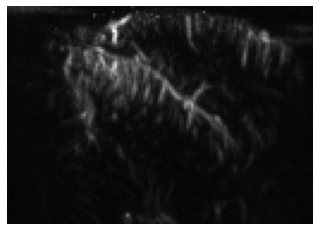

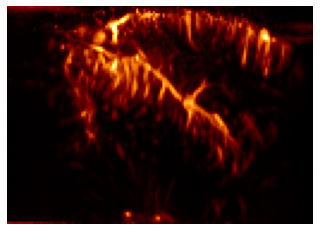

In [360]:
# normalize, display first slice only.
imgN=minmax(mat3D_orig[0,...])

plt.imshow((imgN)**.5, cmap='gist_gray')
plt.axis('off')
plt.show()

# variance maps for 5 to 10 min - note the FFT transform artefacts
varmap = np.var(to2D(mat3D)[10*60:20*60,:], axis=0).reshape(mat3D.shape[1],mat3D.shape[2])

# show the variance map
plt.imshow((varmap)**.2, cmap='afmhot')
plt.axis('off')
plt.show()

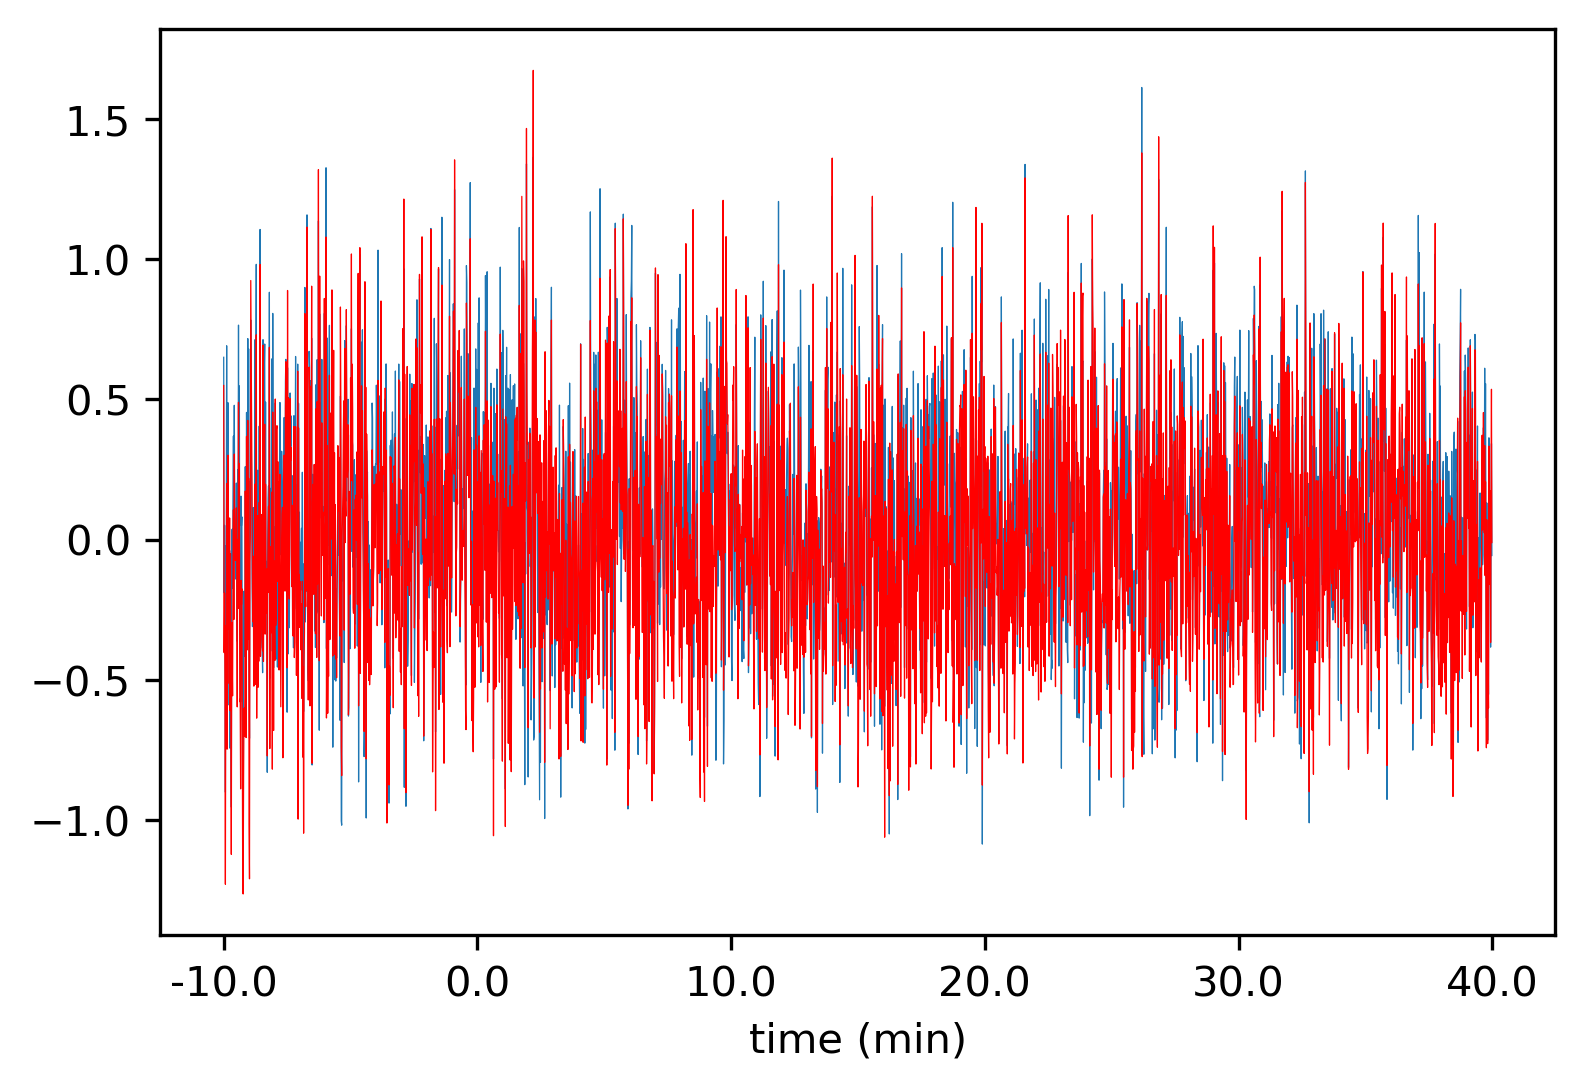

In [361]:
# visualize filtering

n=7888

plt.figure(dpi=300)
plt.plot(to2D(mat3D)[:,n], lw=.3)
plt.plot((to2D(mat3D_corr)[:,n]-np.mean(to2D(mat3D_corr)[:,n])), c='r', lw=.3)
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
plt.show()

In [362]:
def normalize(data):
    return (data-np.mean(data))/np.std(data)

def compareProfiles(baselineTime=[8,10], blockTime=[10,20], squareSignal=False, show=False, norm=False):
    '''
    Compare the mean of the signals within blockTime against the mean of the signals within baselineTime
    '''
    
    baselineMap = mat3D[60*baselineTime[0]:60*baselineTime[1],...].mean(axis=0)
    blockMap = mat3D[60*blockTime[0]:60*blockTime[1],...].mean(axis=0)
    
    plt.hist(mat3D[60*baselineTime[0]:60*baselineTime[1],...].flatten(), bins=50, alpha=.5)
    plt.hist(mat3D[60*blockTime[0]:60*blockTime[1],...].flatten(), bins=50, alpha=.5)
    plt.yscale('log')
    plt.show()
                     
    cbvChange = (blockMap - baselineMap)/np.abs(baselineMap)*100
    #cbvChange = (blockMap/baselineMap-1)*100
                 
    if show==True:        
        fig,ax=plt.subplots(1,3, dpi=300)
        ax[0].imshow(baselineMap, vmin=-15, vmax=15, cmap='inferno', interpolation='none')
        ax[1].imshow(blockMap, vmin=-15, vmax=15, cmap='inferno', interpolation='none')
        
        if squareSignal==True:
            if norm==True:
                ax[2].imshow(normalize(cbvChange**2*np.sign(cbvChange)), cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True), vmin=-1, vmax=1, interpolation='none')
            else:
                ax[2].imshow(cbvChange**2*np.sign(cbvChange), cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True), vmin=-1000, vmax=1000, interpolation='none')
        else:
            if norm==True:
                ax[2].imshow(normalize(cbvChange), cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True), vmin=-1, vmax=1, interpolation='none')
            else:
                ax[2].imshow(cbvChange, cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True), vmin=-200, vmax=200, interpolation='none')
            #plt.colorbar(shrink=.88)
        ax[2].text(20,-2, f"filling ({blockTime[0]}-{blockTime[1]}min) vs baseline ({baselineTime[0]}-{baselineTime[1]}min)")
        
        for axis in ax.flat:
            axis.axis('off')
        plt.show()
    
    return cbvChange

(3000, 91, 128)


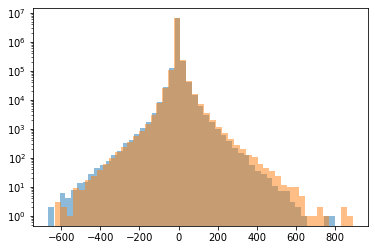

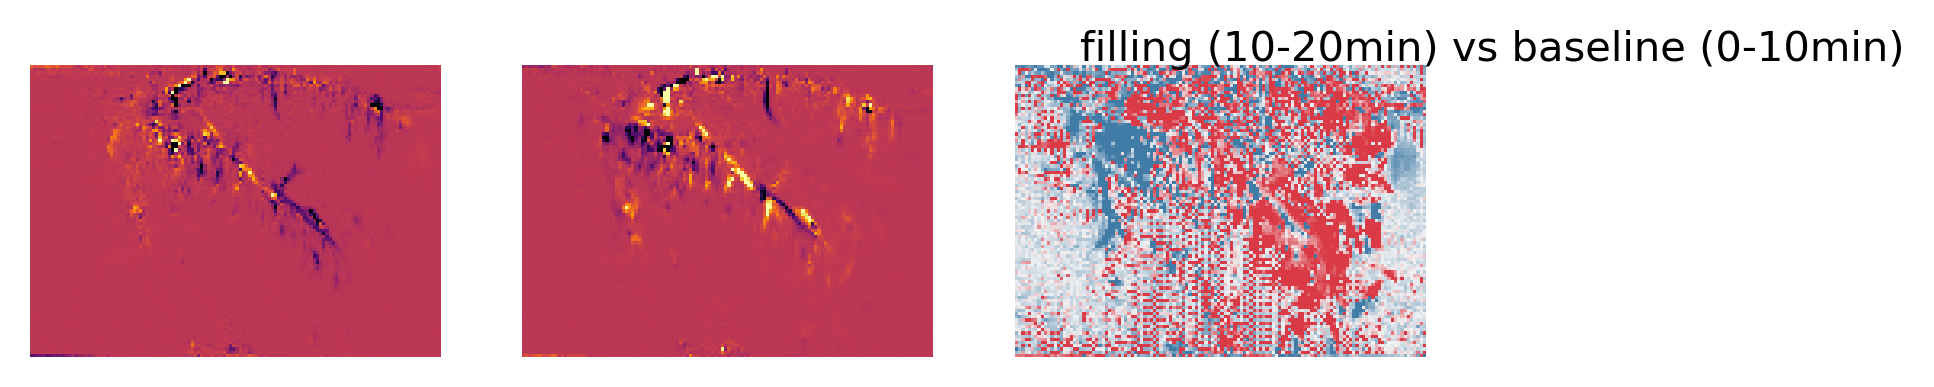

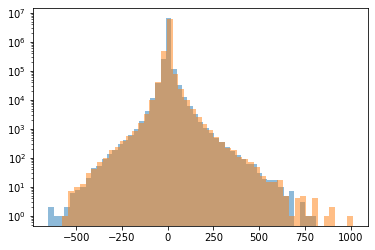

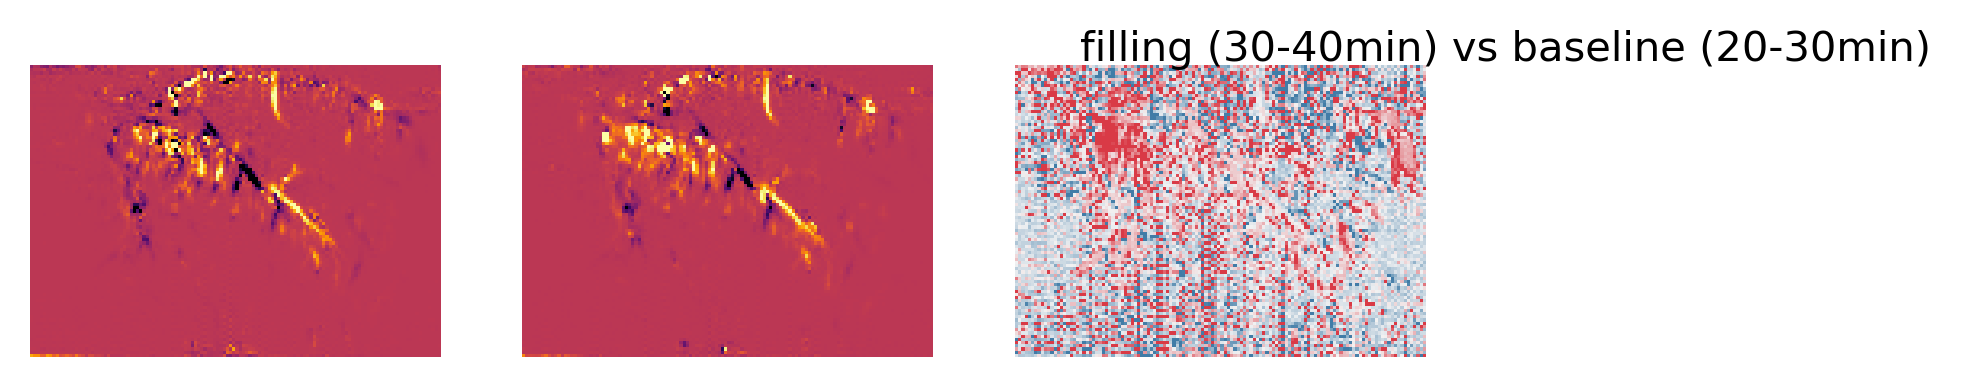

C:\Users\User\AppData\Local\Temp\ipykernel_29380\4114767809.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Spectral_r").copy()
  cmap.set_bad(color='k')


In [363]:
# visualize raw file

print(mat3D.shape)

cbvChange1=compareProfiles(baselineTime=[0,10], blockTime=[10,20], squareSignal=False, norm=False, show=True)
cbvChange2=compareProfiles(baselineTime=[20,30], blockTime=[30,40],squareSignal=False, norm=False, show=True)

#cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True)
cmap=plt.cm.Spectral_r
cmap.set_bad(color='k')

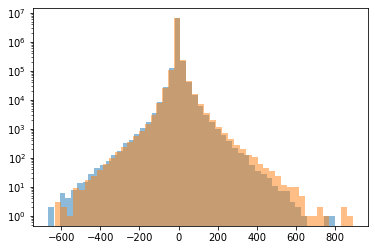

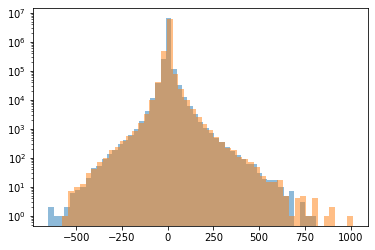

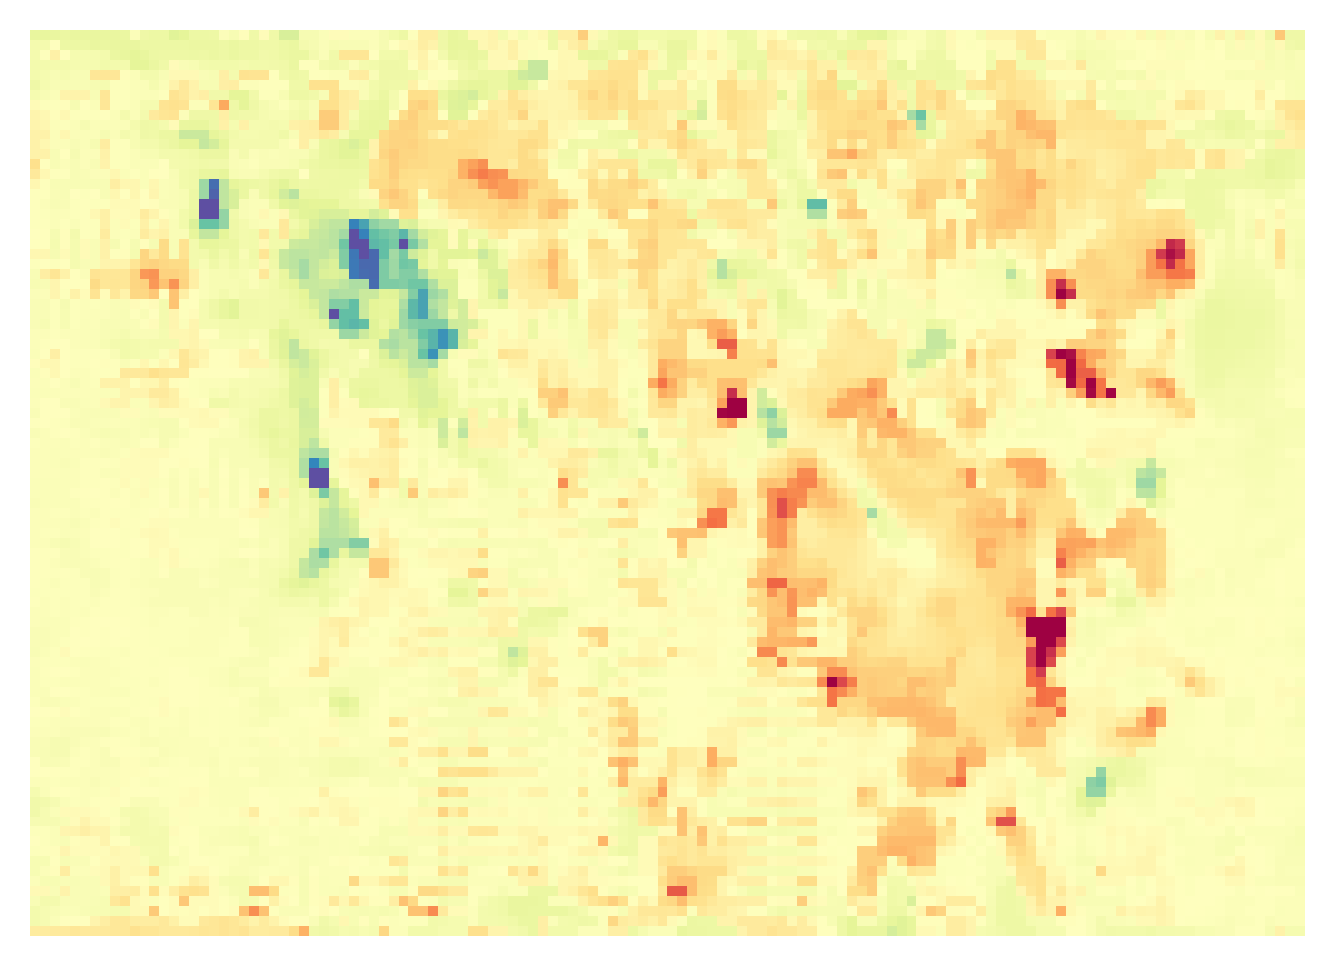

In [364]:
# take average
cbvChange1=compareProfiles(baselineTime=[0,10], blockTime=[10,20], squareSignal=False, norm=False)
cbvChange2=compareProfiles(baselineTime=[20,30], blockTime=[30,40],squareSignal=False, norm=False)

#meanCBVChange=((cbvChange1-np.mean(cbvChange1))/np.std(cbvChange1)+(cbvChange2-np.mean(cbvChange2))/np.std(cbvChange2))/2
#meanCBVChange=(cbvChange1+cbvChange2)/2
meanCBVChange=cbvChange1
meanCBVChange=meanCBVChange.flatten()
#meanCBVChange[visPixels]=np.nan
meanCBVChange=meanCBVChange.reshape(mat3D.shape[1],mat3D.shape[2])

plt.figure(dpi=300)
plt.imshow(median_filter(meanCBVChange, size=3), cmap=cmap, vmin=-1000, vmax=1000, interpolation='none')
plt.axis('off')
plt.show()

244.4628570059064


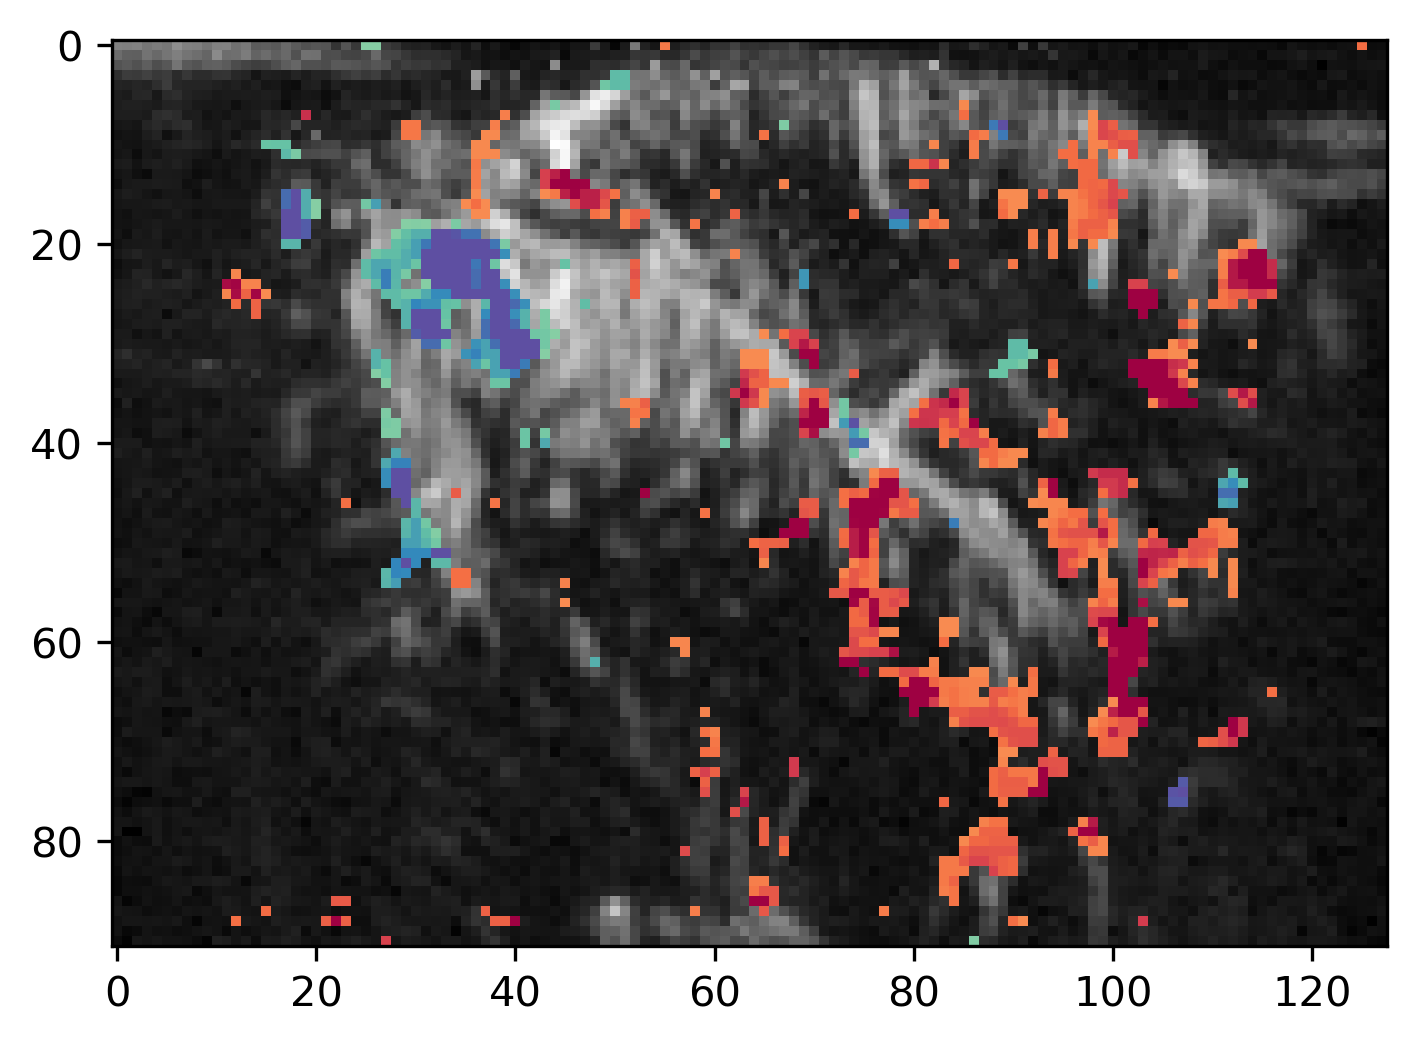

In [365]:
#shows only the top 5 percentile
meanCBVChange=median_filter(meanCBVChange, size=3)
thr=np.percentile(np.abs(meanCBVChange),90)
print(thr)

meanCBVChange[np.abs(meanCBVChange)<thr]=np.nan

cmap=plt.cm.get_cmap("Spectral_r").copy()
cmap.set_bad(alpha=0)

plt.figure(dpi=300)
plt.imshow(np.log(mat3D_orig[0,...]), cmap='gist_gray', interpolation='none')
plt.imshow(meanCBVChange, cmap=cmap, vmin=-thr*2, vmax=thr*2, interpolation='none')
plt.show()

ROI: 1957
160.1664419912816


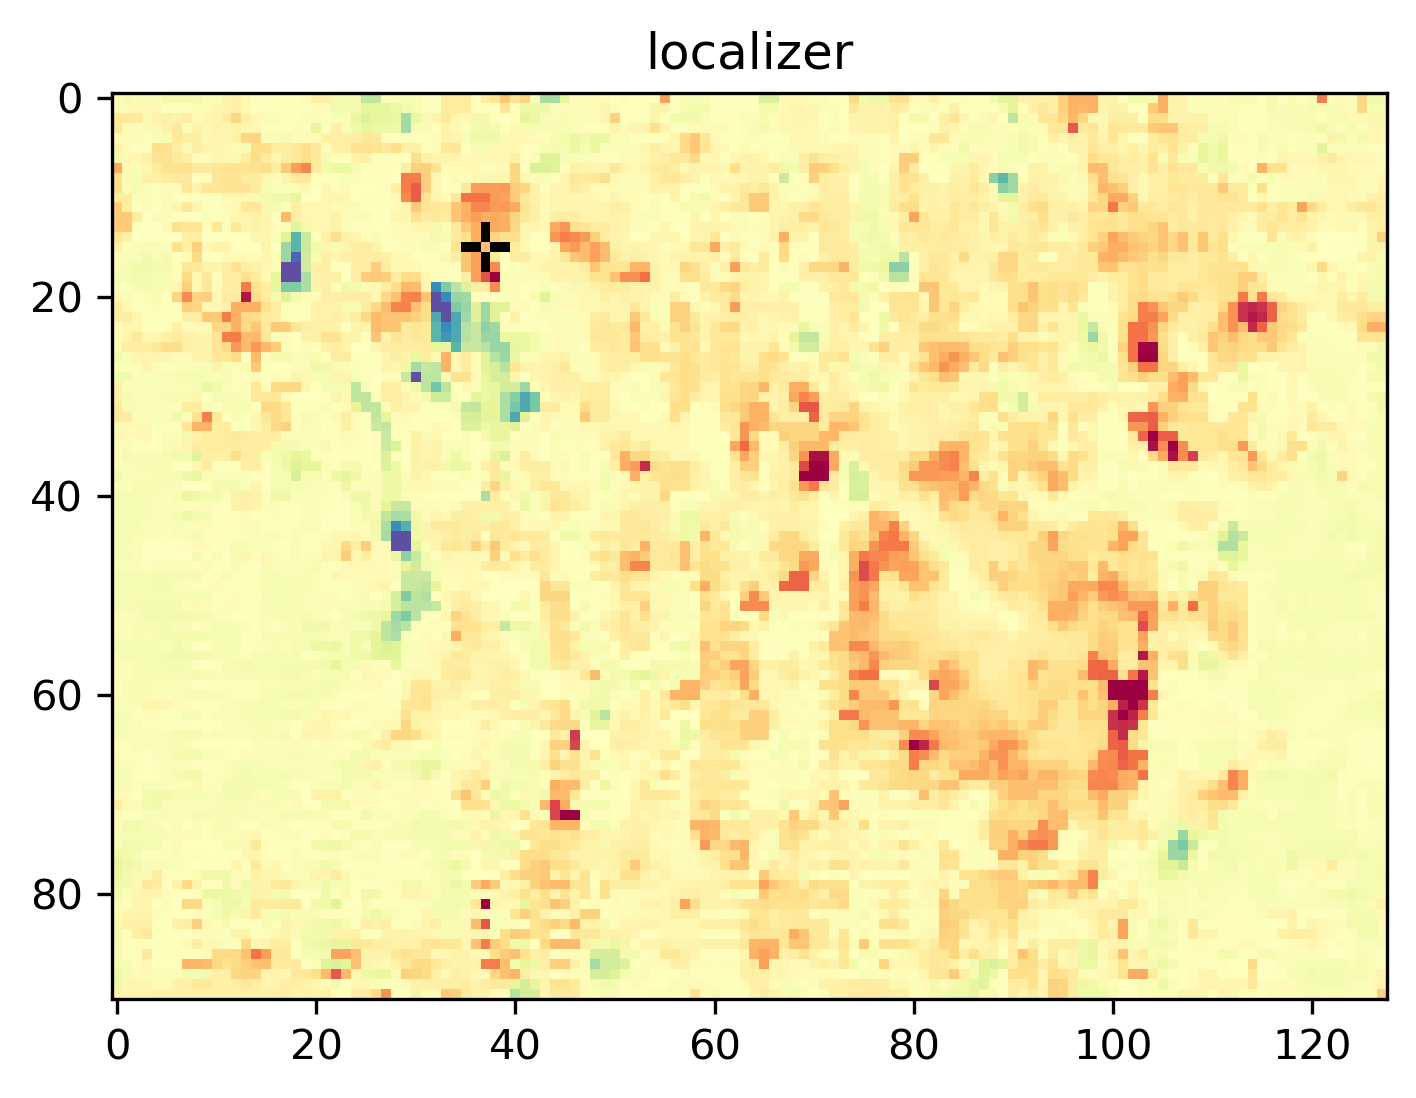

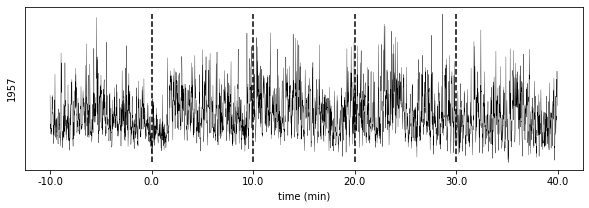

In [366]:
# localizer
# re-run cell above

row=15
column=37
visPixels=row*128+column
#visPixels=1579 # manually specify
print(f'ROI: {row*128+column}')

# regenerate meanCBVChange
meanCBVChange=(cbvChange1+cbvChange2)/2
meanCBVChange=median_filter(meanCBVChange, size=3).flatten()
print(meanCBVChange[visPixels])

# place marker
meanCBVChange[[visPixels+1,visPixels+2,visPixels-1,visPixels-2,visPixels-128,visPixels-128-128,visPixels+128,visPixels+128+128]]=np.nan # make an arrow
meanCBVChange=meanCBVChange.reshape(mat3D.shape[1],mat3D.shape[2])

cmap2=plt.cm.get_cmap("Spectral_r").copy()
cmap2.set_bad(alpha=1, color='k')

plt.figure(dpi=300)
plt.imshow(meanCBVChange, cmap=cmap2, vmin=-thr*2, vmax=thr*2, interpolation='none')
plt.title('localizer')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(mat2D[:,visPixels], lw=.3, c='k')
#plt.plot(mat3D_orig.reshape(mat2D.shape)[:,i], lw=.3, c='gray')

locs=np.array([0,10,20,30,40,50])*60
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
for j in [10,20,30,40]:
    plt.vlines(j*60,ymin=mat2D[:,visPixels].min(), ymax=mat2D[:,visPixels].max(), color='k', linestyle='--')
plt.yticks([]), plt.ylabel(visPixels)
#plt.yscale('symlog')

plt.show()

# bladder pressure

[         text: start fUS
 tick_position: 96749
      channel_: -1
            id: 1
       tick_dt: 0.001
          time: 96.749,
          text: start infusion
 tick_position: 697349
      channel_: -1
            id: 2
       tick_dt: 0.001
          time: 697.349,
          text: end infusion
 tick_position: 1296500
      channel_: 0
            id: 3
       tick_dt: 0.001
          time: 1296.5,
          text: start infusion
 tick_position: 1898099
      channel_: 0
            id: 4
       tick_dt: 0.001
          time: 1898.099,
          text: end infusion
 tick_position: 2496000
      channel_: 0
            id: 5
       tick_dt: 0.001
          time: 2496.0,
          text: end fUS
 tick_position: 3096000
      channel_: 0
            id: 6
       tick_dt: 0.001
          time: 3096.0]

1000


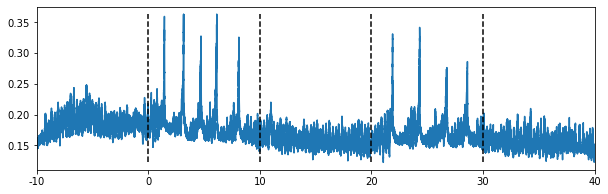

Resampling to 3000 data-points....Resampled.


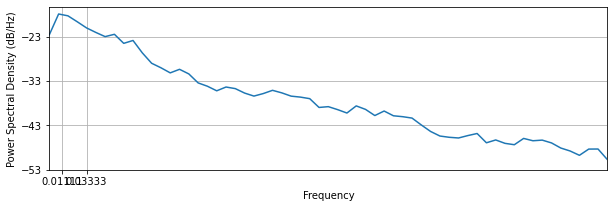

In [456]:
%matplotlib inline
# bladder pressure data
bladder_pressure = [None, #0
                    None, #1
                    (r"ses-Session_2023-11-14_UDS_Rat1_parasagittal\rat1 parasagittal.adicht",3571499), #2 20231114
                    None, #3, the laptop ran out of battery so no coronal
                    (r"ses-Session_2023-11-28_UDS_Parasagittal\20231128 rat1 parasagittal.adicht",154999), #4 20231128
                    (r"ses-Session_2023-11-28_UDS_Coronal\20231128 rat1 coronal.adicht",6699), #5 20231128
                    (r"ses-Session_2023-12-05_UDS_Parasagittal\20231205 parasagittal.adicht",43349), #6 20231205
                    (r"ses-Session_2023-12-05_UDS_Coronal\20231205 coronal2.adicht",152849),#7 20231205, use record 1 instead
                    (r"ses-Session_2023-12-08_UDS_Rat1_parasagittal\20231208 rat1 parasagittal.adicht",32549),#8 20231208
                    (r"ses-Session_2023-12-08_UDS_Rat1_coronal\20231208 Rat1 coronal.adicht",32349), #9 20231208
                    (r"ses-Session_2023-12-11_UDS_Rat1_parasagittal\20231211 parasagittal.adicht",67199), #10 20231211
                    (r"ses-Session_2023-12-11_UDS_Rat1_coronal\20231211 coronal.adicht",96749)] #11 20231211

select_ = 11
fname = bladder_pressure[select_][0].split('\\')[1][:-7]
offset= bladder_pressure[select_][1]
#offset: f.records[0].comments[2].tick_position # extracted from comments, this is when fUS starts
                     
f = adi.read_file(bladder_pressure[select_][0])
# All id numbering is 1 based, first channel, first block
# When indexing in Python we need to shift by 1 for 0 based indexing
# Functions however respect the 1 based notation ...

# see comments
display(f.records[0].comments)

bladder_fs=int(1/f.records[0].comments[0].tick_dt) # per second

print(bladder_fs)

# ivp = intravesical pressure
ivp = f.channels[0].get_data(1) # flip to plot negative as positive, for 7, f.channels[0].get_data(2)
ivp = ivp[offset:offset+bladder_fs*60*50] # take 50 minute from the start of recording

plt.figure(figsize=(10,3))
plt.plot(ivp)
plt.xticks(np.array([0,10,20,30,40,50,60])*bladder_fs*60, [-10,0,10,20,30,40,50])
plt.xlim(np.array([0,50])*bladder_fs*60)
for j in [10,20,30,40]:
    plt.vlines(j*bladder_fs*60,ymin=ivp.min(), ymax=ivp.max(), color='k', linestyle='--')
#plt.xlim(np.array([10,20])*10000*60)
plt.show()

# resample intravesical pressure
print(f'Resampling to {mat2D.shape[0]} data-points...', end='.')
ivpNew=signal.resample(ivp[:60*bladder_fs*50], mat2D.shape[0])
print('Resampled.')

# see PSD for the IVP
plt.figure(figsize=(10,3))
plt.psd(ivpNew[60*10:60*20], NFFT=60*2, noverlap=60, Fs=1, detrend='linear', )
plt.xticks([1/90, 1/30])
plt.xlim([0, 1/2])
plt.show()

# save into mat, only do it once
scipy.io.savemat(f'{fname}.mat', {'bladderpressure': signal.resample(ivp, 1000*60*50)}) # resample to 1K/s

<b>Pause to check that the ivp is correctly aligned!</b>

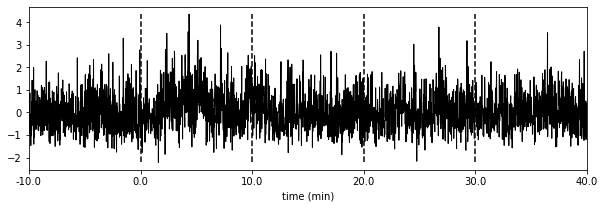

In [369]:
pixel=8528 # example pixel

plt.figure(figsize=(10,3))
#plt.plot(mat2D[:,pixel], c='r', lw=1)
plt.plot(mat2D[:,pixel], c='k', lw=1)

locs=np.array([0,10,20,30,40,50])*60
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
plt.xlim(np.array([0,50])*60)
#plt.xlim(np.array([10,20])*60)
plt.text(15*60,.3,pixel)
for j in [10,20,30,40]:
    plt.vlines(j*60,ymin=mat2D[:,pixel].min(), ymax=mat2D[:,pixel].max(), color='k', linestyle='--')
plt.plot()
plt.show()

Max coherence: 0.252 (pos: 3566) (argmin: 65), Min coherence: 0.003


<IPython.core.display.Javascript object>


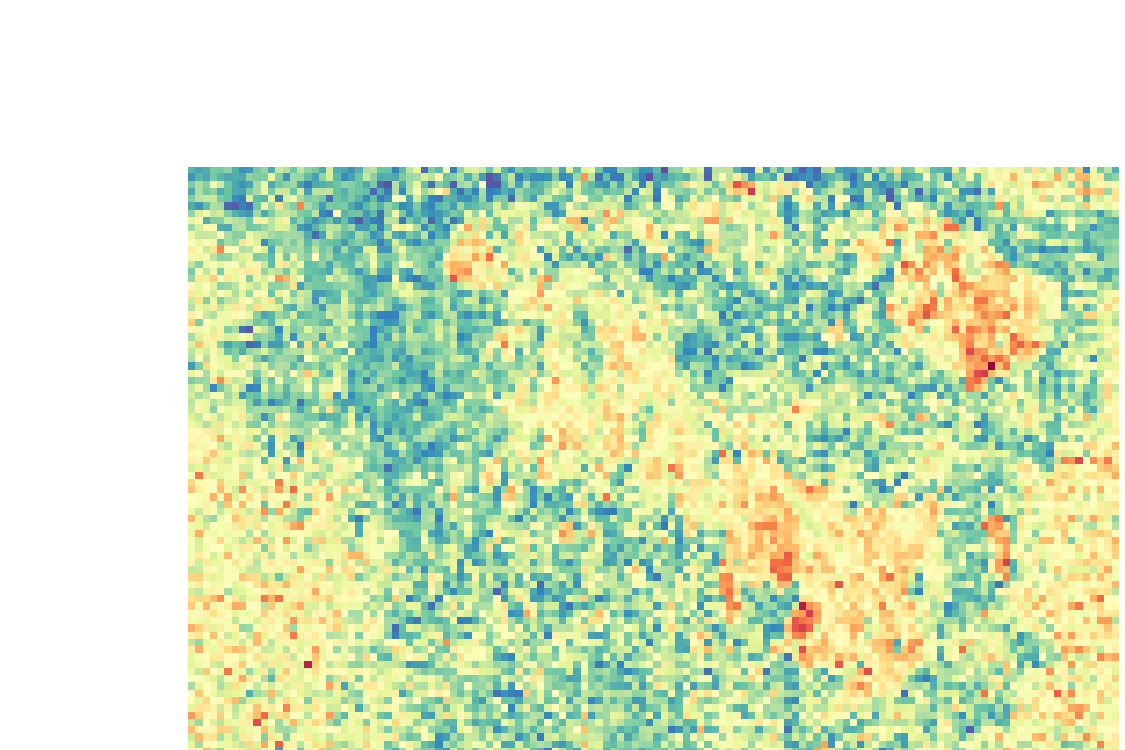

In [419]:
%matplotlib inline
fs=1
nyq = 0.5 * fs    # Nyquist Frequency
order=2

# bandpass between 30s to 90s period
mat2D_bandpass=bandpass(mat2D, [1/(60*5), 1/30], fs=fs, order=order)

coherenceIVP = np.zeros(mat2D.shape[1])

for i in range(mat2D.shape[1]):
    f, Cxy = coherence(mat2D[:,i], ivpNew, 1, nperseg=60*5, noverlap=60*4)
    index=np.where((f>=1/300) & (f<=1/30))
    coherenceIVP[i] = Cxy[index].mean()

Max coherence: 0.252 (pos: 3566) (argmin: 65), Min coherence: 0.003


<IPython.core.display.Javascript object>


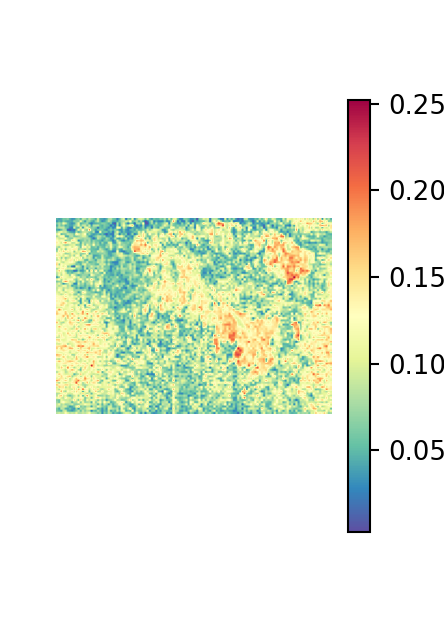

In [427]:
%matplotlib notebook
print(f'Max coherence: {np.max(coherenceIVP):.3f} (pos: {np.argmax(coherenceIVP)}) (argmin: {np.argmin(coherenceIVP)}), Min coherence: {np.min(coherenceIVP):.3f}')    

plt.figure(dpi=300)
plt.imshow(coherenceIVP.reshape(mat3D.shape[1], mat3D.shape[2]), cmap=cmap)
plt.colorbar(shrink=.9)
plt.axis('off')
plt.show()

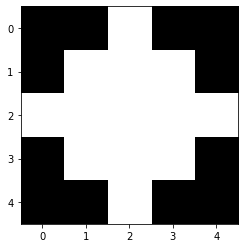

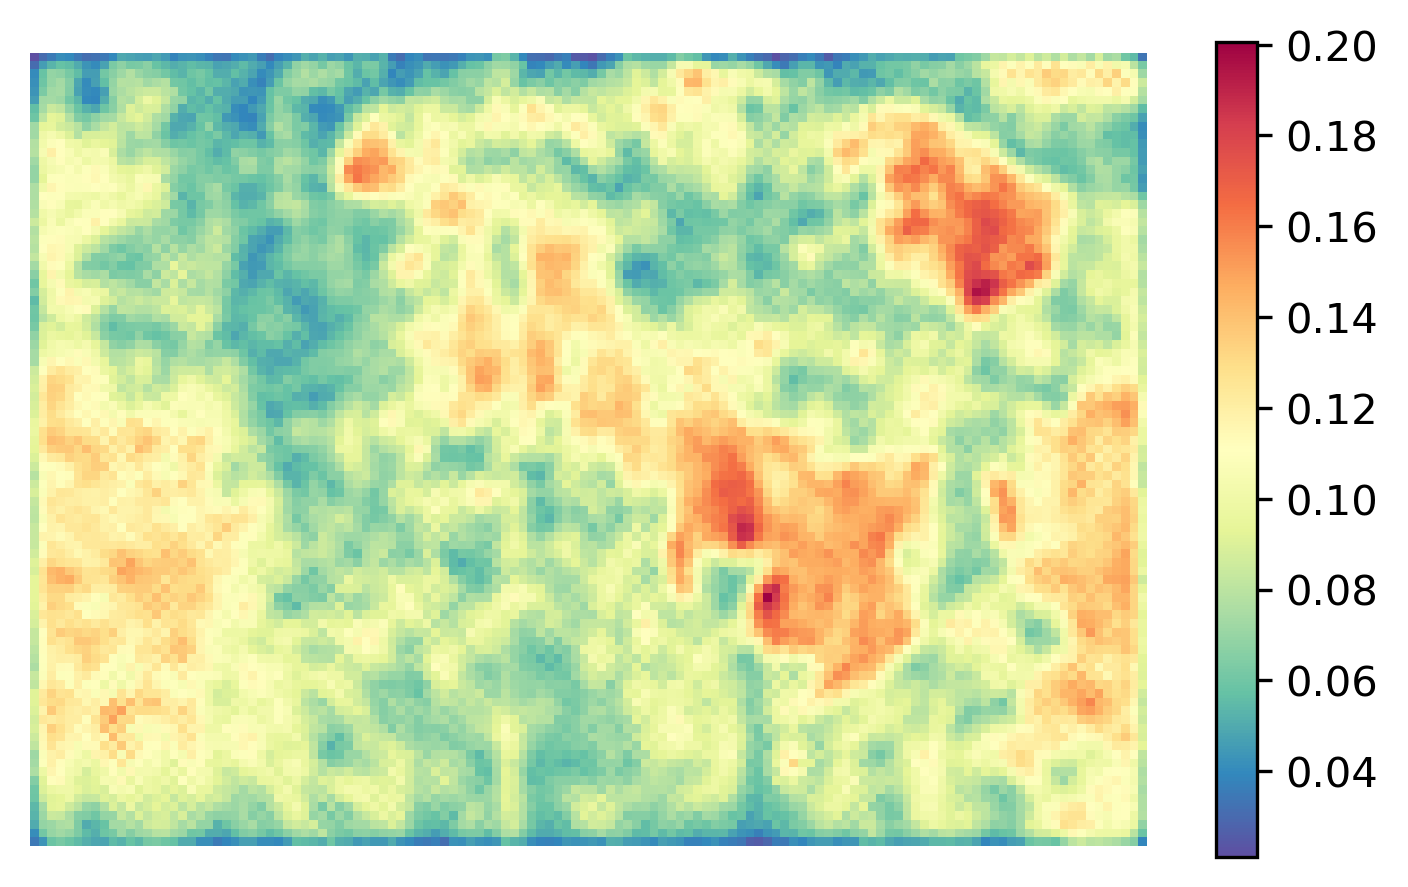

In [371]:
from scipy.signal import convolve2d

%matplotlib inline

def pillbox(x, show=False):
    kernel = np.array([[0,0,1,0,0],[0,1,1,1,0],[1,1,1,1,1],[0,1,1,1,0],[0,0,1,0,0]])/13.
    pillbox = convolve2d(x, kernel, mode='same')
    
    if show==True:
        plt.imshow(kernel, cmap='gist_gray') # radius 2 pillbox
        plt.show()
    
    return pillbox

pB = pillbox(coherenceIVP.reshape(mat3D.shape[1], mat3D.shape[2]), show=True)

plt.figure(dpi=300)
plt.imshow(pB, cmap=cmap)
plt.axis('off')
plt.colorbar(shrink=.9)
plt.show()

Showing position 6865. Coherence: 0.17410001217556445


<IPython.core.display.Javascript object>


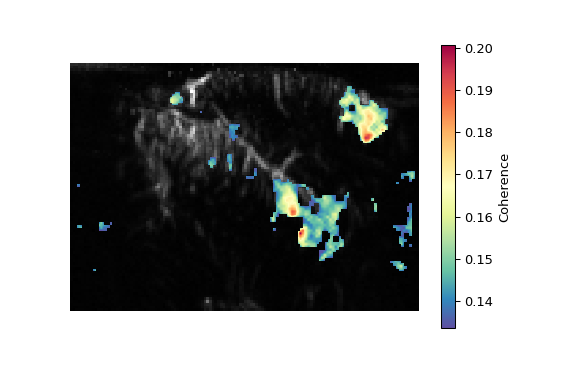

<IPython.core.display.Javascript object>


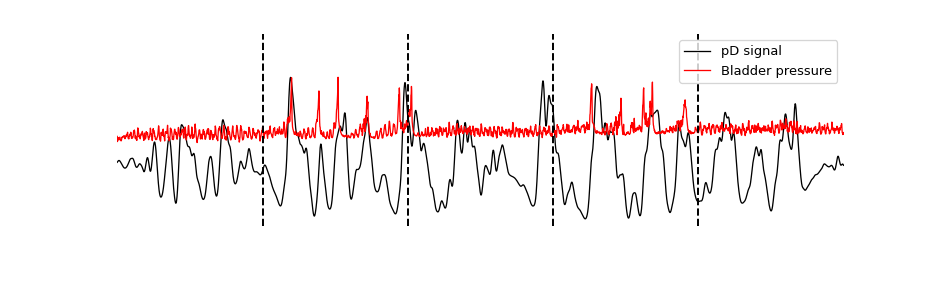

In [434]:
%matplotlib notebook
cc=pB.copy()
# cc=median_filter(coherenceIVP.reshape(mat3D.shape[1], mat3D.shape[2]), size=3)
cc[cc<np.percentile(cc, 90)]=np.nan

row,column=53,81
pixel=row*128+column
#pixel=3125

print(f'Showing position {pixel}. Coherence: {coherenceIVP.flatten()[pixel]}')
selectedROI = np.zeros_like(imgN).flatten()
selectedROI[[pixel+1,pixel+2,pixel-1,pixel-2,pixel-128,pixel-128-128,pixel+128,pixel+128+128]] = 1
selectedROI[selectedROI==0] = np.nan
selectedROI = selectedROI.reshape(imgN.shape)

plt.figure(dpi=100)
plt.imshow(np.sqrt(mat3D_orig[0,...]), cmap='gist_gray', interpolation='none')
plt.imshow(cc, cmap=cmap)
plt.colorbar(label='Coherence')
plt.imshow(selectedROI, cmap='hsv', vmin=0, vmax=1)
plt.axis('off') 
plt.show()

# show waveform
plt.figure(figsize=(10,3), dpi=100)
plt.plot(detrend(mat2D_bandpass[:,pixel]), c='k', lw=1)
plt.plot(ivpNew*(mat2D_bandpass[:,pixel].max()/ivpNew.max()), c='r', lw=1)

locs=np.array([0,10,20,30,40,50])*60
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
plt.xlim(np.array([0,50])*60)
#plt.xlim(np.array([10,20])*60)
plt.ylabel(pixel)
for j in [10,20,30,40]:
    plt.vlines(j*60,ymin=mat2D[:,pixel].min(), ymax=mat2D[:,pixel].max(), color='k', linestyle='--')
plt.ylim([mat2D_bandpass[:,pixel].min()*1.5,mat2D_bandpass[:,pixel].max()*1.5])
plt.legend(['pD signal', 'Bladder pressure'])
plt.axis('off')
plt.show()

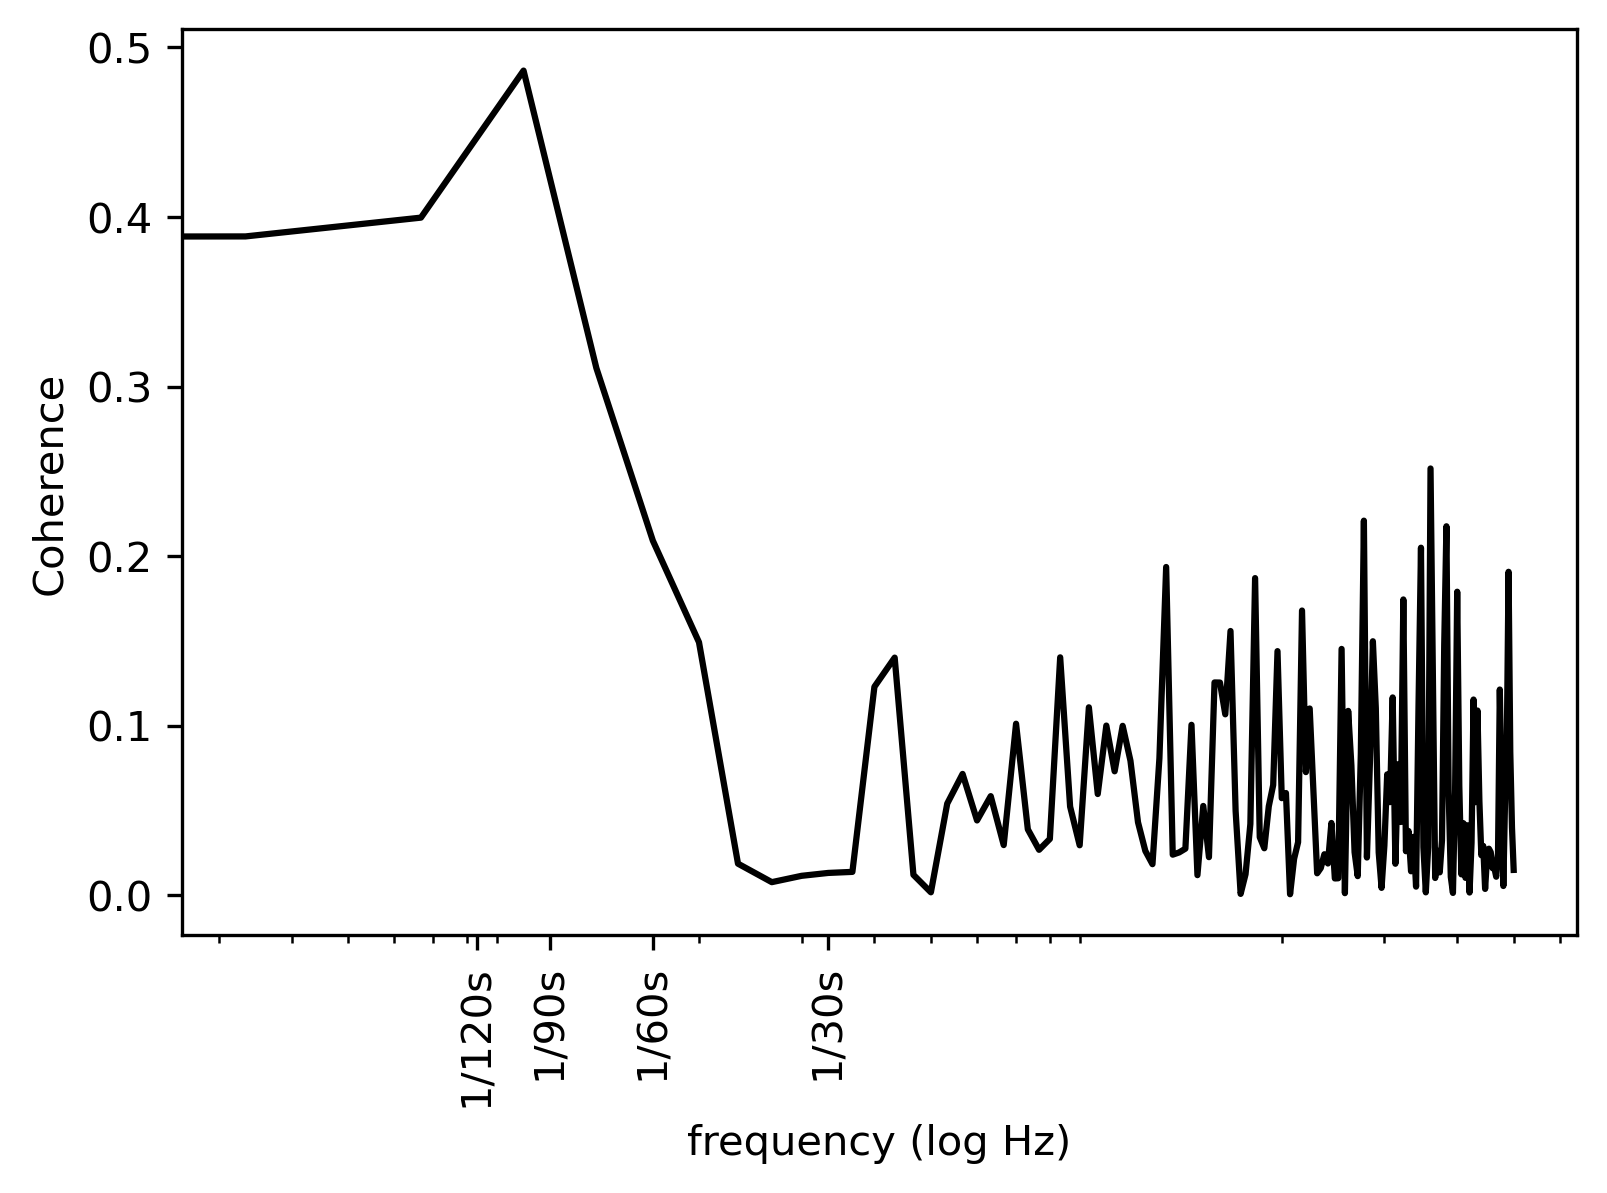

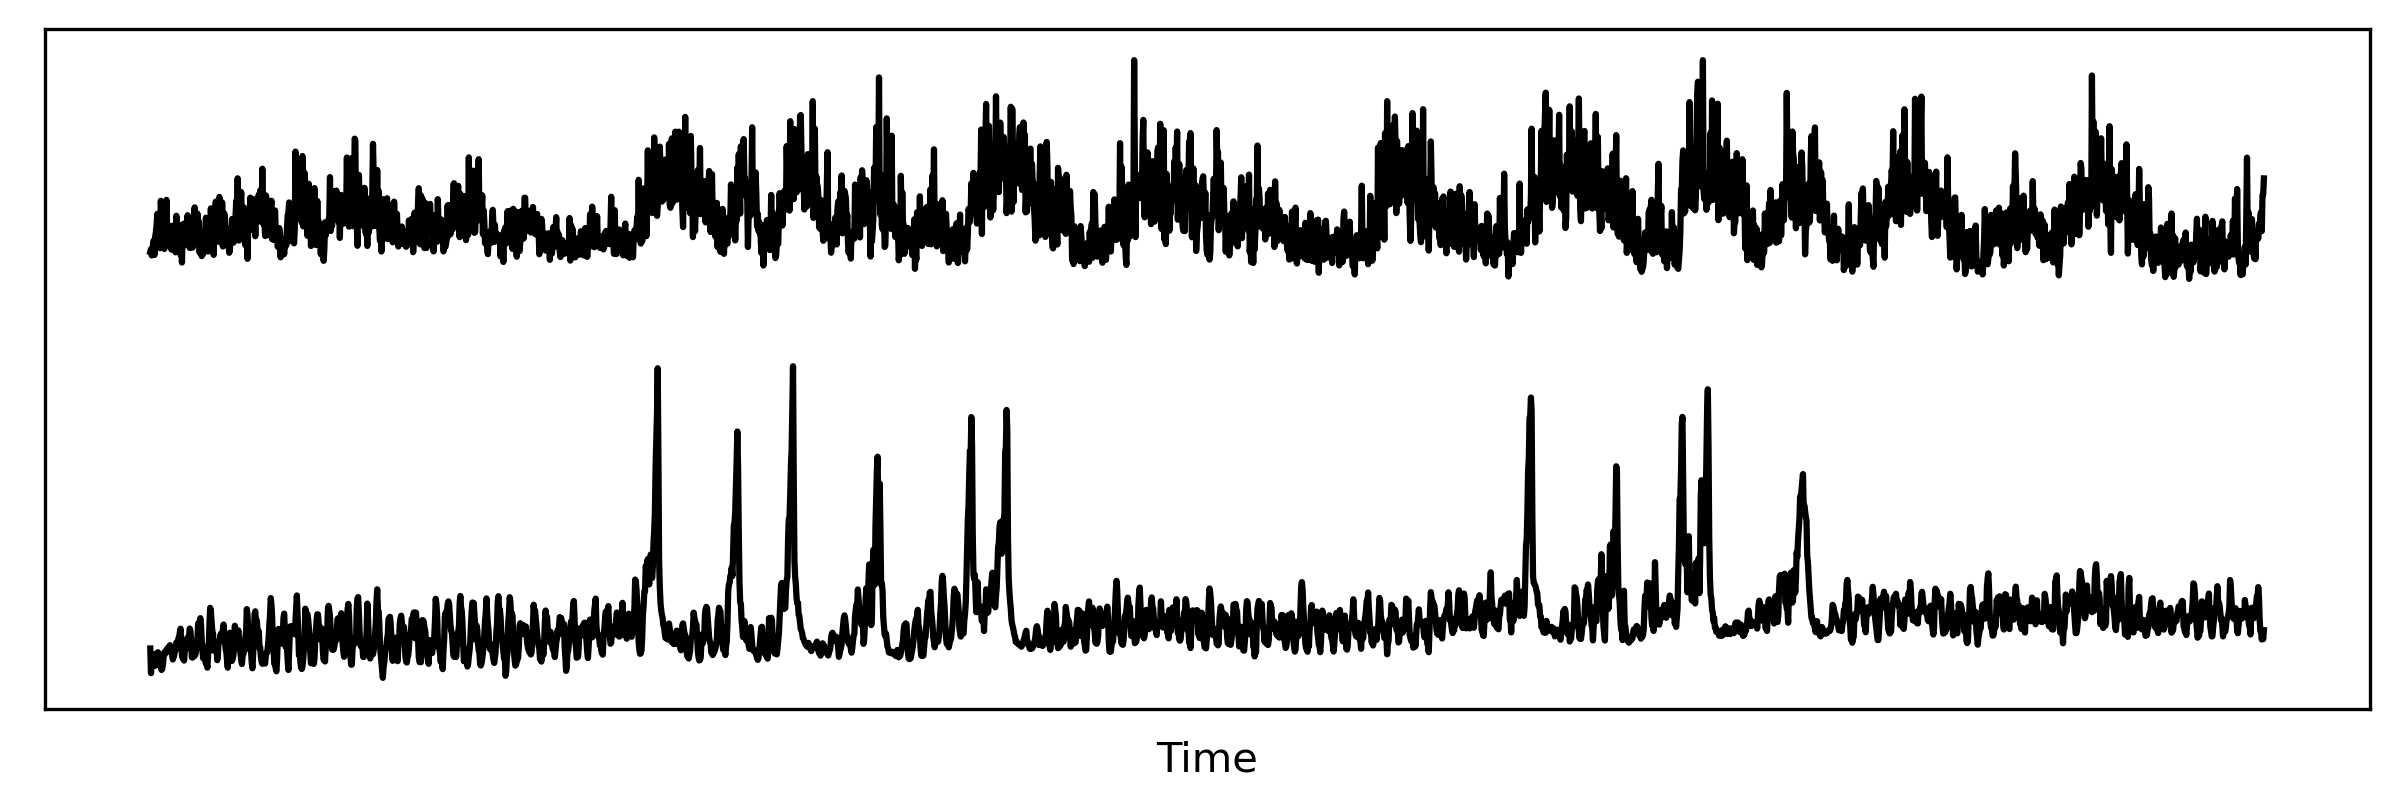

In [395]:
# coherence of the pixel
%matplotlib inline
fig,ax=plt.subplots(dpi=300)
f, Cxy = coherence(mat2D[:,pixel], ivpNew, 1, nperseg=60*5, noverlap=60*4)
ax.semilogx(f, Cxy, c='k')
ax.set_xlabel('frequency (log Hz)')
ax.set_ylabel('Coherence')
ax.set_xticks([1/30, 1/60, 1/90, 1/120], ['1/30s','1/60s','1/90s','1/120s'], rotation=90)
plt.show()

fig,ax=plt.subplots(dpi=300, figsize=(10,3))
plt.plot(normalize(mat2D[:,pixel]), c='k')
plt.plot(normalize(ivpNew)-12, c='k')
ax.set_yticks([]), ax.set_xticks([]), ax.set_xlabel('Time')
plt.show()

In [396]:
mat3D_pillbox = np.zeros_like(mat3D)

for i in range(mat2D.shape[0]):
    mat3D_pillbox[i,...] = pillbox(mat2D_bandpass.reshape(mat3D.shape)[i,...])
    
mat2D_pillbox = mat3D_pillbox.reshape(mat2D.shape)

Calculating time-variant correlation analysis
Offset -4, Max R: 0.263, Min R: -0.263
Offset -3, Max R: 0.267, Min R: -0.272
Offset -2, Max R: 0.271, Min R: -0.281
Offset -1, Max R: 0.272, Min R: -0.290
Offset 0, Max R: 0.282, Min R: -0.297
Offset 1, Max R: 0.290, Min R: -0.302
Offset 2, Max R: 0.298, Min R: -0.306
Offset 3, Max R: 0.303, Min R: -0.308


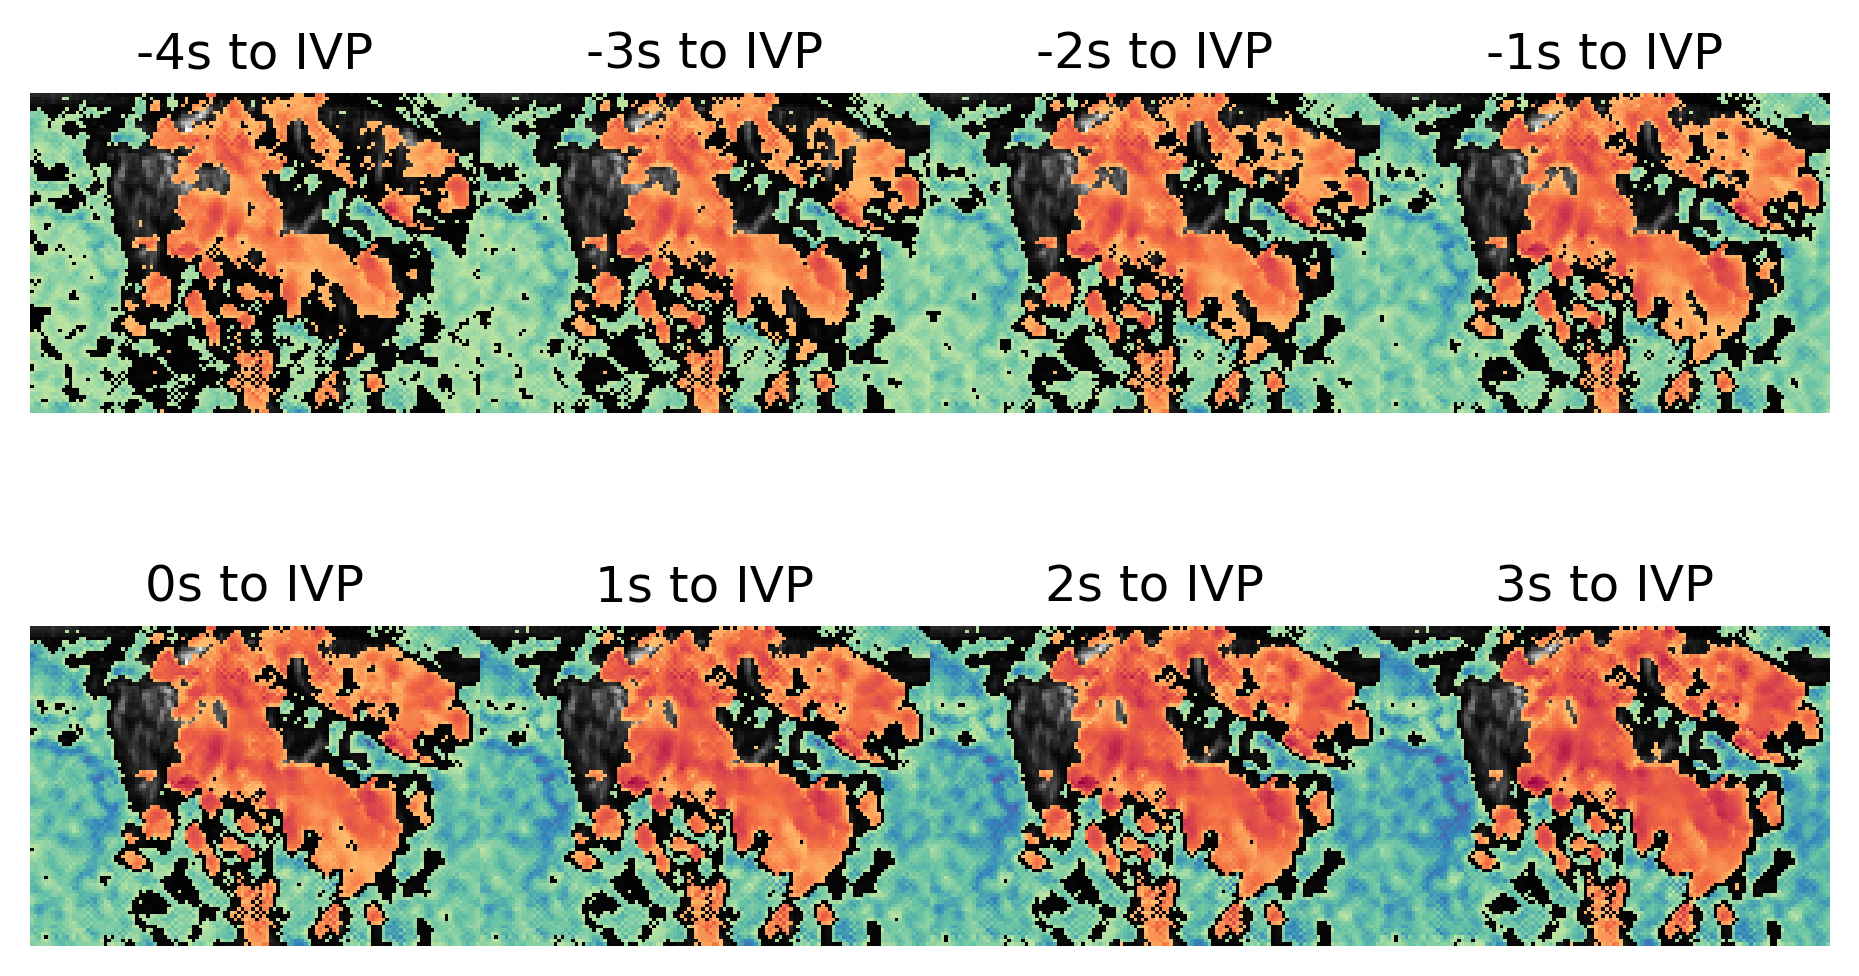

In [397]:
%matplotlib inline
# pearson's
print('Calculating time-variant correlation analysis')

fig,axes=plt.subplots(2,4, dpi=300)

counter=0
corrIVP_all = np.zeros((8,mat3D.shape[1],mat3D.shape[2]))
PcorrIVP_all = np.zeros((8,mat3D.shape[1],mat3D.shape[2]))

for j,ax in zip([-4,-3,-2,-1,0,1,2,3], axes.flat):
#for j in [0]:
    corrIVP=np.zeros(mat2D.shape[1])
    PcorrIVP=np.zeros(mat2D.shape[1]) # stores p values
    
    for i in range(mat2D.shape[1]):
        brainSignal = normalize(mat2D_pillbox[:,i])
        ivpNew_ = normalize(ivpNew)
        
        if j<0:
            j2=np.abs(j)
            corrIVP[i] = pearsonr(brainSignal[:-j2], ivpNew_[j2:]).statistic
            PcorrIVP[i] = pearsonr(brainSignal[:-j2], ivpNew_[j2:]).pvalue
        elif j>0:
            corrIVP[i] = pearsonr(brainSignal[j:], ivpNew_[:-j]).statistic
            PcorrIVP[i] = pearsonr(brainSignal[j:], ivpNew_[:-j]).pvalue
        else:
            corrIVP[i] = pearsonr(brainSignal, ivpNew_).statistic
            PcorrIVP[i] = pearsonr(brainSignal, ivpNew_).pvalue

    print(f'Offset {j}, Max R: {np.max(corrIVP):.3f}, Min R: {np.min(corrIVP):.3f}')    

    # reshape arrays
    corrIVP = corrIVP.reshape(mat3D.shape[1],-1)
    PcorrIVP = PcorrIVP.reshape(mat3D.shape[1],-1)
    
    #store in larger array
    corrIVP_all[counter,...] = corrIVP
    PcorrIVP_all[counter,...] = PcorrIVP

    corrIVP = np.ma.masked_where((PcorrIVP)>(0.001/mat2D.shape[1]), (corrIVP))
    #corrIVP = np.ma.masked_where(np.abs(corrIVP)<(np.percentile(np.abs(corrIVP), 90)), (corrIVP)) # show top 5%

    ax.set_title(f"{j}s to IVP")
    ax.imshow(np.sqrt(mat3D_orig[0,...]), cmap='gist_gray', interpolation='none')
    ax.imshow(corrIVP, cmap=cmap, vmin=-.3, vmax=.3)
    #plt.colorbar()
    ax.axis('off')
    
    counter+=1

plt.tight_layout(pad=0)
plt.show()

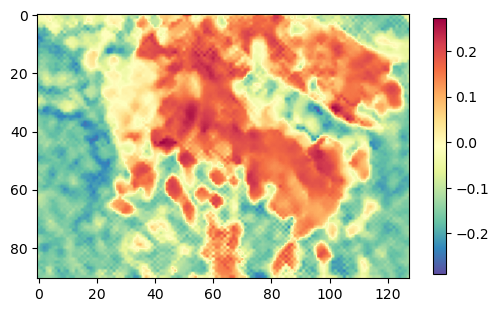

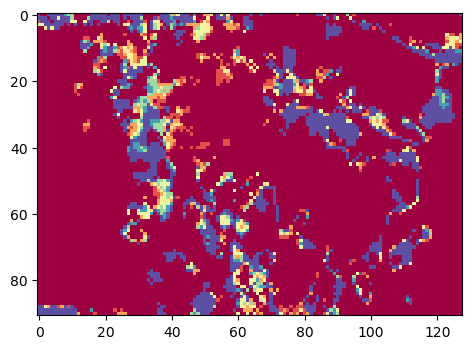

In [411]:
%matplotlib inline
plt.figure(dpi=100)
plt.imshow(corrIVP_all.mean(axis=0), cmap=cmap2)
plt.colorbar(shrink=.85)
plt.show()

plt.figure(dpi=100)
plt.imshow(np.argmax(np.abs(corrIVP_all).reshape(8,-1), axis=0).reshape(mat3D.shape[1],mat3D.shape[2]), cmap=cmap2)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_29380\605420793.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([-4,-3,-2,-1,0,1,2,3])


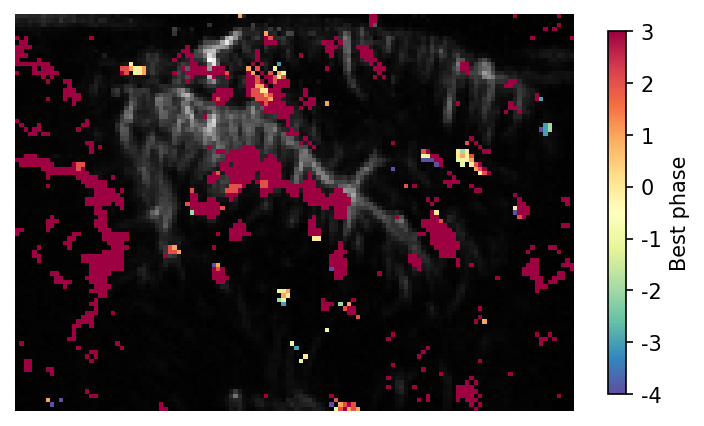

In [402]:
%matplotlib inline
plt.figure(dpi=150)
plt.imshow(np.sqrt(mat3D_orig[0,...]), cmap='gist_gray', interpolation='none')
#plt.imshow(np.ma.masked_where(np.abs(corrIVP_all).reshape(8,-1).mean(axis=0)<np.percentile(np.abs(corrIVP_all).reshape(8,-1).mean(axis=0), 90), np.argmax(np.abs(corrIVP_all).reshape(8,-1), axis=0)).reshape(mat3D.shape[1],mat3D.shape[2]), cmap=cmap)

# percentile criteria
condition1=np.abs(corrIVP_all).reshape(8,-1).mean(axis=0)<np.percentile(np.abs(corrIVP_all).reshape(8,-1).mean(axis=0), 90)
# p value criter
condition2=PcorrIVP_all.reshape(8,-1).mean(axis=0)>(0.01/mat2D.shape[1])
# fixed criteria
condition3=np.abs(corrIVP_all).reshape(8,-1).mean(axis=0)<.13

plt.imshow(np.ma.masked_where(condition1, np.argmax(np.abs(corrIVP_all).reshape(8,-1), axis=0)).reshape(mat3D.shape[1],mat3D.shape[2]), cmap=cmap)
#plt.imshow(np.ma.masked_where(condition1, np.mean((corrIVP_all).reshape(8,-1), axis=0)).reshape(mat3D.shape[1],mat3D.shape[2]), cmap=cmap)

#plt.imshow(np.ma.masked_where(PcorrIVP_all.reshape(8,-1).mean(axis=0)>(0.01/mat2D.shape[1]),np.argmax(np.abs(corrIVP_all).reshape(8,-1), axis=0)).reshape(mat3D.shape[1],mat3D.shape[2]), cmap=cmap)
plt.axis('off')
cbar=plt.colorbar(shrink=.8, label='Best phase')
cbar.ax.set_yticklabels([-4,-3,-2,-1,0,1,2,3])
plt.show()

Showing 62 84 8020


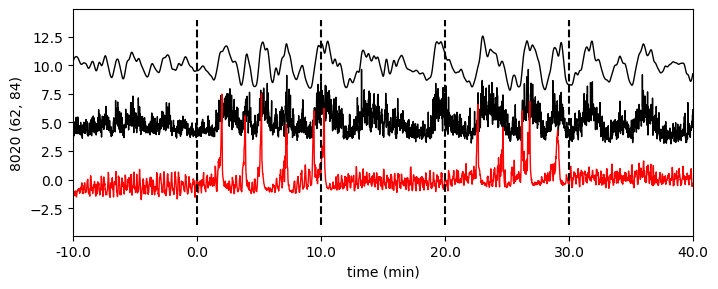

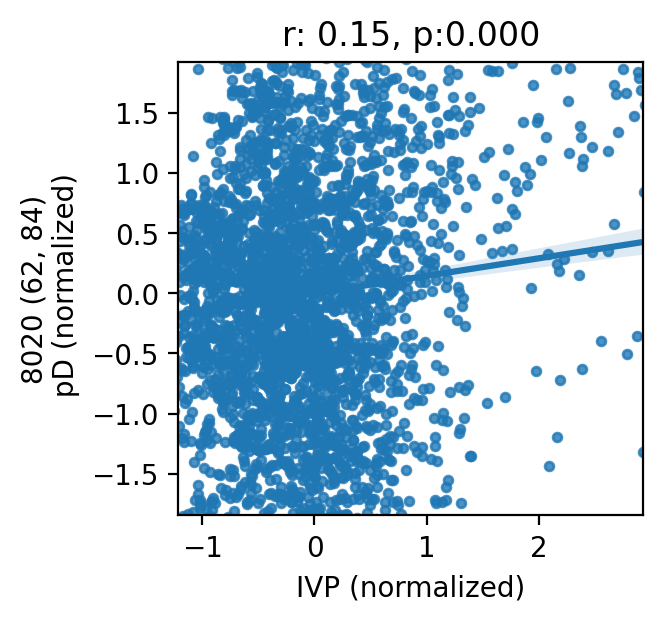

In [403]:
%matplotlib inline
# redefine
# row, column=48,88
# pixel=row*128+column

print('Showing', row, column, pixel)

# Select ROI
# sPixel = []
# for i in np.r_[53:58]:
#     for j in np.r_[91:97]:
#         sPixel = np.append(sPixel, i*128+j)
        
# sPixel

# show waveform
plt.figure(figsize=(8,3), dpi=100)
plt.plot(normalize(mat2D_pillbox[:,pixel])+10, c='k', lw=1)
#plt.plot(normalize(mat2D_pillbox[:,sPixel.astype(int)]).mean(axis=1)+5, c='k', lw=1) # range
plt.plot(normalize(mat2D[:,pixel])+5, c='k', lw=1)
plt.plot(normalize(ivpNew), c='r', lw=1)

locs=np.array([0,10,20,30,40,50])*60
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
plt.xlim(np.array([0,50])*60)
#plt.xlim(np.array([10,20])*60)
plt.ylabel(f'{pixel} ({row}, {column})')
for j in [10,20,30,40]:
    plt.vlines(j*60,ymin=-4, ymax=14, color='k', linestyle='--')
#plt.legend(['pD signal raw', 'pD signal filtered', 'Bladder pressure'])
plt.show()

plt.figure(figsize=(3,3), dpi=200)
sns.regplot(normalize(ivpNew), normalize(mat2D_pillbox[:,pixel]), scatter_kws={'s':10})
plt.xlabel('IVP (normalized)')
plt.ylabel(f'{pixel} ({row}, {column})\n pD (normalized)')
plt.ylim([np.percentile(normalize(mat2D_pillbox[:,pixel]),2.5),np.percentile(normalize(mat2D_pillbox[:,pixel]),97.5)])
plt.xlim([np.percentile(normalize(ivpNew), 2.5), np.percentile(normalize(ivpNew), 97.5)])
plt.title(f'r: {pearsonr(normalize(ivpNew), normalize(mat2D_pillbox[:,pixel])).statistic:.2f}, p:{pearsonr(normalize(ivpNew), normalize(mat2D_pillbox[:,pixel])).pvalue:.3f}')
plt.show()

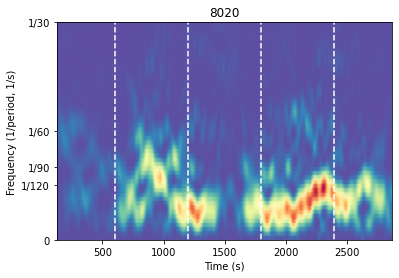

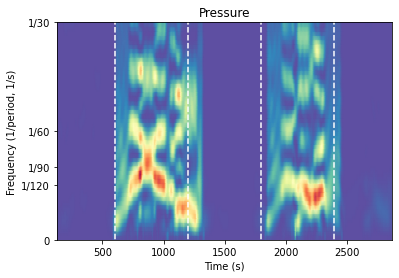

In [404]:
###### from scipy import signal

%matplotlib inline
f, t, Sxx = signal.spectrogram(mat2D_pillbox[:,pixel], 1, nfft=3000//2, noverlap=3000//12)
plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='Spectral_r')
plt.ylabel('Frequency (1/period, 1/s)')
plt.xlabel('Time (s)')
plt.title(f'{pixel}')
plt.ylim([0, 1/30]), plt.yticks([0, 1/120, 1/90, 1/60, 1/30], ['0', '1/120', '1/90', '1/60', '1/30'])
for j in [10,20,30,40]:
    plt.vlines(j*60,ymin=-4, ymax=4, color='w', linestyle='--')
#plt.colorbar(shrink=.9, label='density')
plt.show()

f, t, Sxx = signal.spectrogram(ivpNew, 1, nfft=3000//2, noverlap=3000//12)
plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='Spectral_r')
plt.ylabel('Frequency (1/period, 1/s)')
plt.xlabel('Time (s)')
plt.title('Pressure')
plt.ylim([0, 1/30]), plt.yticks([0, 1/120, 1/90, 1/60, 1/30], ['0', '1/120', '1/90', '1/60', '1/30'])
for j in [10,20,30,40]:
    plt.vlines(j*60,ymin=-4, ymax=4, color='w', linestyle='--')
plt.show()

# Animations

In [ ]:
# animate mat3D_normalized_standardized
import matplotlib.animation as animation

fs = 1            # sample rate, Hz
period=60         # period in seconds
cutoff = 1/period # desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs    # Nyquist Frequency
order = 2         # sin wave can be approx represented as quadratic

print(f"Applying lowpass filter ({cutoff:.4f}Hz)...", end=' ')
mat3D_lowpass = to3D(lowpass(mat2D, cutoff, fs=fs, order=order))
print('Applied.')

# calculate z score map
baseline_map = mat3D_lowpass[:60*2,...].mean(axis=0)
zscore = (mat3D_lowpass-baseline_map[np.newaxis,...])

# mask it
zscore_masked = np.ma.masked_where(np.abs(zscore)<np.percentile(np.abs(zscore.flatten()),90), zscore)

In [ ]:
print(f"Total frames: {mat3D.shape[0]}")

# init the figure
fig, ax = plt.subplots(figsize=(5,5))

print('running frame:', end=" ")
def update(i):
    global frames
    
    # skip even frames
    if i%2>0:
        return
    
    print(i, end=" ")
    
    if ((np.floor(i/60)>=10) & (np.floor(i/60)<20)) | ((np.floor(i/60)>=30) & (np.floor(i/60)<40)):
        status = 'infuse'
        tcolor = 'r'
    else:
        status = 'rest'
        tcolor = 'w'
        
    title_text = f'{np.floor(i/60).astype(int):02d}:{np.round(i%60):02d} ({status})'
    
    #ax.clear()
    plt.gca().clear()

    plt.imshow(np.sqrt(mat3D_orig[0,...]), cmap='gist_gray', interpolation='none')
    plt.imshow(zscore_masked[i,...], cmap=cmap, vmin=-100, vmax=100)
    
    ax.text(0,20,title_text,fontsize=8, color=tcolor)
    plt.tight_layout(pad=0)
    plt.axis('off')

import time
    
ani = animation.FuncAnimation(fig, update, frames=mat3D.shape[0], interval=1)
ani.save(f'rat{select}_uds_coronal_{time.time()}.gif', writer='pillow', fps=30)

In [ ]:
# plot map to be exported
# a colormap and a normalization instance
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=2)

tslice=15

plt.imshow(np.sign(zscore[int(tslice*60),...])*np.sqrt(np.abs(zscore[int(tslice*60),...])), cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True), vmin=0, vmax=2)
plt.axis('off')
plt.imsave(f'rat{select}_uds.png', cmap(norm(zscore[int(tslice*60),...].astype(float))))
# save as image
plt.show()

# go to MS paint to manually draw out the ROI
# rename the file to 'mouseX_roi.png'

<b>Open MSPaint now</b> to edit the map, then continue

In [ ]:
image = imageio.imread(f'rat{select}_uds_vlpag.png')[:,:,3].astype(float)

# dichotomize
image[image>image.min()]=1
image[image==image.min()]=np.nan

# generate mask
mask_indices = image.flatten()>0

plt.imshow(image, cmap='gist_gray')
plt.xticks([]),plt.yticks([])
plt.show()

assert image.shape == mat3D.shape[1:3]
assert mask_indices.sum()>0

# show the map over

plt.imshow(zscore[int(11*60),...], cmap=cmap, alpha=1, vmin=0, vmax=2)
plt.imshow(image, cmap='Accent', alpha=.7)
plt.xticks([]),plt.yticks([])
plt.show()

In [ ]:
# calculate mean change over time
roi_signal = np.zeros(mat3D.shape[0])
roi_rest = np.zeros(mat3D.shape[0])
roi_all = np.zeros(mat3D.shape[0])

print(f'Number of pixels in ROI: {sum(mask_indices)}')
print(f'Number of pixels in total: {len(mask_indices)}')

# %pD change
mat3Dn = mat3D/normal_map

for i in range(mat3D.shape[0]):
    roi_signal[i]=mat3Dn[i,:,:].flatten()[mask_indices.astype(bool)].mean()
    roi_rest[i]=mat3Dn[i,:,:].flatten()[~mask_indices.astype(bool)].mean()
    roi_all[i]=mat3Dn[i,:,:].flatten().mean()
    
roi_signal = pd.DataFrame(roi_signal, columns=['pD'])
roi_signal.index = (roi_signal.index+1)/60
#display(roi_signal)

roi_rest = pd.DataFrame(roi_rest, columns=['pD'])
roi_rest.index = (roi_rest.index+1)/60

roi_all = pd.DataFrame(roi_all, columns=['pD'])
roi_all.index = (roi_all.index+1)/60

# plot the signal over time
plt.figure(figsize=(10,2))
plt.plot(roi_signal, c='r', lw=1)
#plt.plot(roi_rest, c='b', lw=.5)
plt.plot(roi_all, c='k', lw=.5)
#plt.plot(roi_signal/roi_all)

#-- vertical lines and labels -- #
a=roi_signal.min()*.9
b=roi_signal.max()*1.1
plt.vlines(10,a,b,color='gray', alpha=.5)
plt.vlines(30,a,b,color='gray', alpha=.5)

plt.vlines(20,a,b,color='gray', alpha=.5, linestyle='dotted')
plt.vlines(40,a,b,color='gray', alpha=.5, linestyle='dotted')

h=roi_signal.min()
plt.text(13.35,h,'Infuse',fontsize=9, c='r')
plt.text(23.35,h,'Rest',fontsize=9, c='g')
plt.text(33.35,h,'Infuse',fontsize=9, c='r')
plt.text(43.35,h,'Rest',fontsize=9, c='g')
#-- vertical lines and labels -- #

#-- Annotate --#
pee = [12,13.5,15,17,32,34.8,36.3,39]

for i in pee:
    closestIndex = np.argmin(np.abs(roi_signal.index-i))
    plt.text(i, roi_signal.iloc[np.argmin(np.abs(roi_signal.index-i))].pD+.5, '▾')

plt.title('VLPAG')
plt.xticks([0,10,20,30,40,50])
plt.ylabel('pD change'),plt.xlabel('min')
plt.show()

# zoom in plot
# plt.figure(figsize=(3,.5))
# plt.plot(roi_signal, c='k', lw=1)
# plt.vlines(5,0,roi_signal.max()*1.1,color='r', alpha=.5),plt.vlines(10,0,roi_signal.max()*1.1,color='g', alpha=.5)
# plt.ylim([roi_signal.pD.min()*.9, roi_signal.pD.max()*1.1])
# plt.xlabel('min'),plt.yticks([])
# plt.xlim([0,5])
# plt.show()

In [ ]:
new_cutoff = 0.01
y = butter_lowpass_filter(roi_signal.pD.values, new_cutoff, fs, order)

roi_signal_filtered = pd.DataFrame(y, columns=['pD'])
roi_signal_filtered.index = (roi_signal_filtered.index+1)/60

plt.figure(figsize=(10,2))
plt.plot(roi_signal_filtered, c='k', lw=1)

#-- vertical lines and labels -- #
a=roi_signal.min()*.9
b=roi_signal.max()*1.1
plt.vlines(10,a,b,color='gray', alpha=.5)
plt.vlines(30,a,b,color='gray', alpha=.5)

plt.vlines(20,a,b,color='gray', alpha=.5, linestyle='dotted')
plt.vlines(40,a,b,color='gray', alpha=.5, linestyle='dotted')

h=roi_signal.min()
plt.text(13.35,h,'Infuse',fontsize=9, c='r')
plt.text(23.35,h,'Rest',fontsize=9, c='g')
plt.text(33.35,h,'Infuse',fontsize=9, c='r')
plt.text(43.35,h,'Rest',fontsize=9, c='g')
#-- vertical lines and labels -- #

#-- Annotate --#
pee = [12,13.5,15,17,32,34.8,36.3,39]

for i in pee:
    closestIndex = np.argmin(np.abs(roi_signal.index-i))
    plt.text(i, roi_signal.iloc[np.argmin(np.abs(roi_signal.index-i))].pD+.5, '▾')

plt.title('LPAG')
plt.xticks([0,10,20,30,40,50])
plt.ylabel('pD change'),plt.xlabel('min')
plt.show()

In [ ]:
# plot individual pixels in ROI as line graph
bypixel = mat2D[:,mask_indices.astype(bool)]
plt.imshow(bypixel.T, aspect='auto', cmap='Spectral_r')

In [ ]:
nsignal=np.log(abs(roi_signal/roi_all))

plt.figure(figsize=(10,2))
plt.plot(nsignal, c='k', lw=1)

#-- vertical lines and labels -- #
a=nsignal.min()*.9
b=nsignal.max()*1.1
plt.vlines(5,a,b,color='r', alpha=.5),plt.vlines(10,a,b,color='g', alpha=.5)
plt.vlines(6,a,b,color='gray', alpha=.5)
plt.vlines(7,a,b,color='gray', alpha=.5)
plt.vlines(8,a,b,color='gray', alpha=.5)
plt.vlines(9,a,b,color='gray', alpha=.5)

plt.vlines(5.5,a,b,color='gray', alpha=.5, linestyle='dotted')
plt.vlines(6.5,a,b,color='gray', alpha=.5, linestyle='dotted')
plt.vlines(7.5,a,b,color='gray', alpha=.5, linestyle='dotted')
plt.vlines(8.5,a,b,color='gray', alpha=.5, linestyle='dotted')
plt.vlines(9.5,a,b,color='gray', alpha=.5, linestyle='dotted')



h=nsignal.max()*.9
plt.text(5.05,h,'ON',fontsize=7, c='r')
plt.text(5.55,h,'OFF',fontsize=7, c='g')
plt.text(6.05,h,'ON',fontsize=7, c='r')
plt.text(6.55,h,'OFF',fontsize=7, c='g')
plt.text(7.05,h,'ON',fontsize=7, c='r')
plt.text(7.55,h,'OFF',fontsize=7, c='g')
plt.text(8.05,h,'ON',fontsize=7, c='r')
plt.text(8.55,h,'OFF',fontsize=7, c='g')
plt.text(9.05,h,'ON',fontsize=7, c='r')
plt.text(9.55,h,'OFF',fontsize=7, c='g')
#-- vertical lines and labels -- #

plt.ylabel('log(pD_ROI / pD_all)'),plt.xlabel('min')
plt.show()

In [ ]:
# periodogram

fs=1

from scipy import signal
#(f, S) = signal.periodogram(roi_signal.pD.values, fs, scaling='density')
(f, S)= scipy.signal.welch(roi_signal.pD.values, fs, nperseg=200)

plt.figure(figsize=(3,1))
plt.semilogy(f, S)
#plt.xlim([0,1])
#plt.ylim([1e-4, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Backup codes

In [ ]:
# apply filter

# bandpass filter pixel-wise
fs = 1            # sample rate, Hz
period=30         # period in seconds
cutoff = 1/period # desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs    # Nyquist Frequency
order = 2         # sin wave can be approx represented as quadratic
T = 5.0           # Sample Period
n = int(T * fs)   # total number of samples

# filter between periods of 1 (freq of voiding) and 10 (freq of bladder infusion)
print(1/(np.array([10,1])*60))
#mat2D_filtered = bandpass(mat2D, 1/(np.array([100,1])*60), fs=fs, order=order) #1/(np.array([10,1])*60)
    
# remove baseline drift (subtract by the median)
# mat2D_filtered -= np.median(mat2D_filtered,axis=1)[:, np.newaxis]
    
# regenerate fUS images after bandpass filter
# mat3D = to3D(mat2D_filtered)

In [ ]:
# pixelwise normalization (over time) of the bandpassed signal
mat2D_norm = (mat2D_filtered-mat2D_filtered.mean(axis=0))/mat2D_filtered.std(axis=0)

print(mat3D.shape)
plt.imshow(mat2D_norm.T, aspect='auto', cmap='Spectral_r', vmin=-1, vmax=1), plt.colorbar()
plt.ylabel('pixels'), plt.xlabel('time (s)')
locs=np.array([0,10,20,30,40,50])*60
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
plt.show()

In [ ]:
import scipy.stats as stats

def findP(baseline, test):
    '''
    Calculate the p value for a given pixel
    
    baseline:     The pD map for the baseline (array)
    test:         The pD map for the test (array)
    '''
    _, pvalue = stats.ttest_ind(baseline, test)
    
    return pvalue

pvmap = np.zeros(mat2D.shape[1]) #p value maps

stimOn = np.arange(10*60,20*60)
stimOff = np.arange(8*60,10*60)

for i in range(mat2D.shape[1]):
    pvmap[i] = findP(mat3D.reshape(mat3D.shape[0],-1)[stimOn,i],mat3D.reshape(mat3D.shape[0],-1)[stimOff,i])
    
#reshape pv map
pvmap = pvmap.reshape(mat3D.shape[1], mat3D.shape[2])

# p value threshold
pthres = .01/mat2D.shape[1]

print('P value map')

# show the p value map itself
plt.imshow(pvmap, cmap='viridis')
plt.axis('off')
plt.show()

# plot pvmap with p value below threshold
plt.imshow(pvmap<pthres, cmap='viridis', alpha=.9)
plt.imshow(np.log(imgN), cmap='gist_gray', alpha=.5) # 2 min baseline
#plt.title('P value maps')
plt.axis('off')
# save as image
plt.show()

#
# despeckle with median filter
pvmap_filtered = median_filter(pvmap<pthres, size=2)

# plot the despeckled pvmap with p value below threshold
plt.imshow(pvmap_filtered, cmap='viridis', alpha=.9)
plt.imshow(np.log(normal_map), cmap='gist_gray', alpha=.5) # 2 min baseline
#plt.title('P value maps')
plt.axis('off')
# save as image
plt.show()

# save as pvmap2
pvmap2 = pvmap.copy()

<b>variance map</b>

In [ ]:
# variance maps
mat2D = mat3D.reshape(mat3D.shape[0],-1)
varmap = np.var(mat2D, axis=0).reshape(mat3D.shape[1],mat3D.shape[2])

# show the variance map
plt.imshow(np.log(varmap), cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# variance map export
mask = (varmap>np.percentile(varmap,99)).astype(float)
mask[mask==0]=np.nan

plt.imshow(np.log(varmap), cmap='gist_gray', alpha=.5)
plt.imshow(mask, cmap='hsv', alpha=1)
#plt.title('P value maps')
plt.axis('off')
plt.savefig(f'mouse{select}.png', bbox_inches='tight', pad_inches=0)
# save as image
plt.show()

# a colormap and a normalization instance
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=1)

# map the normalized data to colors
# image is now RGBA (512x512x4) 
image = cmap(norm((varmap>np.percentile(varmap,99)).astype(float)))

# save the image
plt.imsave(f'mouse{select}_varmap.png', image)

# go to MS paint to manually draw out the ROI
# rename the file to 'mouseX_varroi.png'

In [ ]:
# generate heatmap
median_map = np.median(mat3D[:60*5,:,:],axis=0)

mat3D_lowpass = mat3D.copy()
# low pass filter 0.01Hz
for i in range(mat3D.shape[1]):
    for j in range(mat3D.shape[2]):
        mat3D_lowpass[:,i,j] = butter_lowpass_filter(mat3D_lowpass[:,i,j], 0.05, 1, 2)
        
mat3D_normalized = mat3D_lowpass-median_map[np.newaxis,:]
mat3D_normalized_standardized = (mat3D_normalized - mat3D_normalized.mean(axis=(1,2))[:, np.newaxis, np.newaxis]) / (mat3D_normalized.std(axis=(1,2))[:, np.newaxis, np.newaxis])

mat3D_normalized_standardized[np.abs(mat3D_normalized_standardized)<1] = 0

# apply median filter
for i in range(mat3D_normalized_standardized.shape[0]):
    mat3D_normalized_standardized[i,:,:] = median_filter(mat3D_normalized_standardized[i,:,:], size=3)
    mat3D_normalized_standardized[i,:,:][np.abs(mat3D_normalized_standardized[i,:,:])<1] = np.nan
    
plt.imshow(np.log(median_map), cmap='gist_gray', alpha=.5)
plt.imshow((mat3D_normalized_standardized[60*30,:,:]), cmap='Spectral_r', alpha=.7)
#plt.imshow(median_filter(mat3D_normalized_standardized[60*30,:,:], size=3), cmap='viridis', alpha=.7)
#plt.title('P value maps')
plt.axis('off')
plt.colorbar()
#plt.savefig(f'mouse{select}.png', bbox_inches='tight', pad_inches=0)
# save as image
plt.show()

In [ ]:
# animate mat3D_normalized_standardized
import matplotlib.animation as animation

# init the figure
fig, ax = plt.subplots(figsize=(5,5))

print('running frame:', end=" ")
def update(i):
    global frames
    
    print(i, end=" ")
    
    if (np.floor(i/60)>=5) & (np.floor(i/60)<10):
        status = 'stim on'
    else:
        status = 'stim off'
    title_text = f'{np.floor(i/60)} min {i%60} sec ({status})'
    
    ax.clear()
    plt.imshow(np.log(median_map), cmap='gist_gray', alpha=.5)
    plt.imshow((mat3D_normalized_standardized[i,:,:]), cmap='Spectral_r', alpha=.7)
    plt.title(title_text)
    plt.tight_layout(pad=0)
    plt.axis('off')

ani = animation.FuncAnimation(fig, update, frames=mat3D.shape[0], interval=1)
ani.save(f'mouse{select}_video.gif', writer='pillow', fps=30)

In [ ]:
def register(idx):
    '''
    rigid affine transform: https://pystackreg.readthedocs.io/en/latest/
    
    ---
    alternative: skimage phase_cross_correlation(mat3D_orig[0,...], mat3D_orig[2000,...])
    '''

    ref=mat3D_orig[0,...]
    img=mat3D_orig[idx,...]
    
    sr = StackReg(StackReg.BILINEAR) #Python implementation of the ImageJ/Fiji StackReg plugin
    sr.register(ref>np.percentile(ref,95), img>np.percentile(img,95)) # register only using the brightest spots
    img_ = sr.transform(img)
    missing = (img_==0)
    img_[missing] = np.median(img_) # replace 0  with median
    
    return img_, missing

In [ ]:
# skimage ORB and RANSAC registration
# https://www.gilgalad.co.uk/post/image-registration-skimage/
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.transform import ProjectiveTransform, SimilarityTransform
from skimage.measure import ransac
from skimage.feature import plot_matches
from skimage.transform import warp

def orb_ransac(idx):
    ref=mat3D_orig[0,...]
    img=mat3D_orig[idx,...]

    orb = ORB(n_keypoints=500, fast_threshold=0.05)
    orb.detect_and_extract(ref>np.percentile(ref,90))
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors

    orb.detect_and_extract(img>np.percentile(img,90))
    keypoints2 = orb.keypoints
    descriptors2 = orb.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

    # Select keypoints from the source (image to be registered) and target (reference image)
    src = keypoints2[matches12[:, 1]][:, ::-1]
    dst = keypoints1[matches12[:, 0]][:, ::-1]

    if src.shape[0]<10: # invalid image, just load in the previous one
        return mat3D_corr[idx-1,...], np.zeros_like(mat3D_corr[idx-1,...])
        
    model_robust, inliers = ransac((src, dst), PiecewiseAffineTransform,min_samples=10, residual_threshold=1, max_trials=300)

    ref_ = ref
    output_shape = ref.shape
    
    img_ = warp(img, model_robust.inverse, preserve_range=True,output_shape=output_shape, cval=np.median(img))
    missing = (img_==-1)
    img_[img_==-1] = np.median(img_) # fill missing values as median
    
#     fig,ax=plt.subplots(1,4)
#     ax[0].imshow(ref)
#     ax[1].imshow(img)
#     ax[2].imshow(img_)
#     ax[3].imshow(missing)
    
    return img_,missing